## Meteo Bakery - LightGBM optimized
In this notebook, we will implement and optimized LightGBM algorithm based on GridSearch results and assess feature importance.

### import libraries

In [11]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import os

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

from lightgbm import LGBMRegressor
import shap

### load data

In [12]:
df = pd.read_csv('../data/data_combined.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

branch        product     turnover  year  month  week  \
date                                                               
2012-01-01  Metro    Brown Bread   134.735759  2012      1    52   
2012-01-01  Metro    Wheat Rolls   150.104897  2012      1    52   
2012-01-01  Metro          Cakes   322.635866  2012      1    52   
2012-01-01  Metro       Pastries  1047.327119  2012      1    52   
2012-01-01  Metro  Savoury Snack   816.663466  2012      1    52   

            day_of_month  day_of_week  school_holiday  public_holiday  ...  \
date                                                                   ...   
2012-01-01             1            6           False            True  ...   
2012-01-01             1            6           False            True  ...   
2012-01-01             1            6           False            True  ...   
2012-01-01             1            6           False            True  ...   
2012-01-01             1            6           False            True  ...   

           clouds_mean_dev  wind_speed_mean_dev  wind_dir_x_mean_dev  \
date                                                                   
2012-01-01             NaN                  NaN                  NaN   
2012-01-01             NaN                  NaN                  NaN   
2012-01-01             NaN                  NaN                  NaN   
2012-01-01             NaN                  NaN                  NaN   
2012-01-01             NaN                  NaN                  NaN   

            wind_dir_y_mean_dev  rain_1h_mean_dev  snow_1h_mean_dev  \
date                                                                  
2012-01-01                  NaN               NaN               NaN   
2012-01-01                  NaN               NaN               NaN   
2012-01-01                  NaN               NaN               NaN   
2012-01-01                  NaN               NaN               NaN   
2012-01-01                  NaN               NaN               NaN   

            visibility_mean_dev  temp_mean_change  pressure_mean_change  \
date                                                                      
2012-01-01                  NaN               NaN                   NaN   
2012-01-01                  NaN               NaN                   NaN   
2012-01-01                  NaN               NaN                   NaN   
2012-01-01                  NaN               NaN                   NaN   
2012-01-01                  NaN               NaN                   NaN   

            humidity_mean_change  
date                              
2012-01-01                   NaN  
2012-01-01                   NaN  
2012-01-01                   NaN  
2012-01-01                   NaN  
2012-01-01                   NaN  

[5 rows x 87 columns]

### transform periodic month feature using sine and cosine functions

In [13]:
df['month_sin'] = df.month.apply(lambda x: np.sin(np.array(x) * np.pi /6))
df['month_cos'] = df.month.apply(lambda x: np.cos(np.array(x) * np.pi /6))

### select only years up to 2020

In [14]:
df = df[df.year<2020]

### generate lag features
Will we use sales with a lag of 7 and 365 days, since these days showed peaks in partical autocorrelation plots.

In [15]:
# utility function for generating lagged features
def get_lag_features(df, grouping_vars, feature, lags):
    """Takes in a stacked time series dataframe and generates lag features for defined lags and returns dataframe with lags as
    additional columns.

    Args:
        df (pd.DataFrame): Stacked time series dataframe
        grouping_vars (list): A list of grouping variables. Currently accepts only a list of two variables.
        feature (str): Name of the feature, for which lags should be generated.
        lags (list): A list of lags to generate lag features

    Returns:
        df (pd.DataFrae): A Dataframe containing the lag features as additional columns.
    """
    # initialize empty dataframe
    df_lag = pd.DataFrame({})
    
    for i, group in enumerate(product(df[grouping_vars[0]].unique(), df[grouping_vars[1]].unique())):
        # subselect time series and generate lag features
        ts = df[(df[grouping_vars[0]]==group[0]) & (df[grouping_vars[1]]==group[1])].copy()
        # map feature to dictionary
        target_map = ts[feature].to_dict()
        # iterate over every lag, map feature according to lag and append to dataframe
        for lag in lags:
            ts[f'{feature}_lag_{lag}'] = (ts.index - pd.Timedelta(f'{lag} days')).map(target_map)
            
        df_lag = pd.concat([df_lag, ts], axis=0)
    
    return df_lag

### for completeness, also write function for generating lead features

In [16]:
# utility function for generating lead features
def get_lead_features(df, grouping_vars, feature, leads):
    """Takes in a stacked time series dataframe and generates lead features for defined leads and returns dataframe with leads as
    additional columns.

    Args:
        df (pd.DataFrame): Stacked time series dataframe
        grouping_vars (list): A list of grouping variables. Currently accepts only a list of two variables.
        feature (str): Name of the feature, for which leads should be generated.
        leads (list): A list of leads to generate lead features

    Returns:
        df (pd.DataFrae): A Dataframe containing the lead features as additional columns.
    """
    # initialize empty dataframe
    df_lead = pd.DataFrame({})
    
    for i, group in enumerate(product(df[grouping_vars[0]].unique(), df[grouping_vars[1]].unique())):
        # subselect time series and generate lead features
        ts = df[(df[grouping_vars[0]]==group[0]) & (df[grouping_vars[1]]==group[1])].copy()
        # map feature to dictionary
        target_map = ts[feature].to_dict()
        # iterate over every lead, map feature according to lead and append to dataframe
        for lead in leads:
            ts[f'{feature}_lead_{lead}'] = (ts.index + pd.Timedelta(f'{lead} days')).map(target_map)
            
        df_lead = pd.concat([df_lead, ts], axis=0)
    
    return df_lead

In [17]:
df_lag = get_lag_features(df, ['branch', 'product'], 'turnover', [7, 365])

In [18]:
df_lag[(df_lag.index >= pd.to_datetime('2012-12-20')) & (df_lag['branch']=='Metro') & (df_lag['product']=='Brown Bread')][['turnover', 'turnover_lag_7', 'turnover_lag_365']].head(10)

turnover  turnover_lag_7  turnover_lag_365
date                                                    
2012-12-20         NaN      295.893355               NaN
2012-12-21  244.955686      254.628960               NaN
2012-12-22  184.717103      146.717674               NaN
2012-12-23  193.829831      254.673158               NaN
2012-12-24  239.509610      332.501967               NaN
2012-12-25  201.753851      247.704726               NaN
2012-12-26  270.141135      251.315049               NaN
2012-12-27  264.102446             NaN               NaN
2012-12-28  196.525496      244.955686               NaN
2012-12-29  157.519108      184.717103               NaN

In [33]:
df_lead = get_lead_features(df_lag, ['branch', 'product'], 'temp_mean', [1])
df_lead = get_lead_features(df_lead, ['branch', 'product'], 'rain_1h_mean', [1])
df_lead = get_lead_features(df_lead, ['branch', 'product'], 'snow_1h_mean', [1])

In [36]:
df_lead[(df_lead['branch']=='Metro') & (df_lead['product']=='Brown Bread')][['temp_mean', 'temp_mean_lead_1', 'turnover_lag_7']].tail()

temp_mean  temp_mean_lead_1  turnover_lag_7
date                                                   
2019-12-27   4.949333          2.084000      284.016714
2019-12-28   2.084000          0.770000      219.208529
2019-12-29   0.770000          0.734667      188.939133
2019-12-30   0.734667          6.331333      282.942562
2019-12-31   6.331333               NaN      221.121285

### replace missing values
Previous analyes showed that a couple of days are missing from the sales data. For the branch located at the Metro and Train Station, there is a total of 4 missing days. By contrast, 69 days are missing for Center branch in the years 2012-2019. They frequently fall on a public holiday, thus indicating that this branch probably had closed on these days.
We will first replace NaNs at Center branch by 1 if occuring on public holiday. Remaining NaNs will be replaced with turnover of corresponding day of preceding weak, otherwise, a forward fill will be used.

In [37]:
df_lead.groupby(['branch', 'product'])['turnover', 'month'].count()

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


turnover  month
branch        product                       
Center        Brown Bread        2853   2922
              Cakes              2855   2922
              Pastries           2855   2922
              Savoury Snack      2855   2922
              Wheat Rolls        2855   2922
Metro         Brown Bread        2916   2922
              Cakes              2918   2922
              Pastries           2918   2922
              Savoury Snack      2918   2922
              Wheat Rolls        2918   2922
Train_Station Brown Bread        2916   2922
              Cakes              2918   2922
              Pastries           2918   2922
              Savoury Snack      2918   2922
              Wheat Rolls        2918   2922

In [38]:
df_repl = df_lead.copy()

# replace NaN at Center branch by 0 is occuring on public holiday
df_repl.loc[(df_repl['branch']=='Center') & (df_repl['public_holiday']==True), 'turnover'] = df_repl.loc[(df_repl['branch']=='Center') & (df_repl['public_holiday']==True), 'turnover'].fillna(1)

# fill NaN with sales from previous day of week
df_repl['turnover'] = df_repl['turnover'].fillna(df_repl['turnover_lag_7'])

# fill remaining NaN using forward fill
#df_repl['turnover'].ffill(inplace=True, axis='rows')
for i, group in enumerate(product(df_repl['branch'].unique(), df_repl['product'].unique())):
        df_repl[(df_repl['branch']==group[0]) & (df_repl['product']==group[1])].ffill(inplace=True, axis='rows')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
# check if replacement worked properly for an example date with a missing
df_repl[(df_repl.index == pd.to_datetime('2012-02-22')) & (df_repl['branch']=='Train_Station')][['turnover', 'turnover_lag_7']]

turnover  turnover_lag_7
date                                  
2012-02-22  102.954132      102.954132
2012-02-22  103.480607      103.480607
2012-02-22   75.790842       75.790842
2012-02-22  591.949157      591.949157
2012-02-22  750.840940      750.840940

In [40]:
df_repl.groupby(['branch', 'product'])[['turnover', 'turnover_lag_7', 'month']].count()

turnover  turnover_lag_7  month
branch        product                                       
Center        Brown Bread        2922            2848   2922
              Cakes              2922            2850   2922
              Pastries           2922            2850   2922
              Savoury Snack      2922            2850   2922
              Wheat Rolls        2922            2850   2922
Metro         Brown Bread        2922            2909   2922
              Cakes              2922            2911   2922
              Pastries           2922            2911   2922
              Savoury Snack      2922            2911   2922
              Wheat Rolls        2922            2911   2922
Train_Station Brown Bread        2922            2909   2922
              Cakes              2922            2911   2922
              Pastries           2922            2911   2922
              Savoury Snack      2922            2911   2922
              Wheat Rolls        2922            2911   2922

### generate train and test df

In [41]:
df_train = df_repl[df_repl.year<2018]
df_test = df_repl[df_repl.year>=2018]

### Time Series Split Cross Validation
Number of splits is set to 52 and test sizeto 7 days, thus representing a whole year. For now, we won't introduce any gab between training and validation set. However, assuming that bakery stores usually make their demand planning for the upcoming week on certain days of the week, e.g. Thursdays, we may later additionally introduce a gap of 3 days.

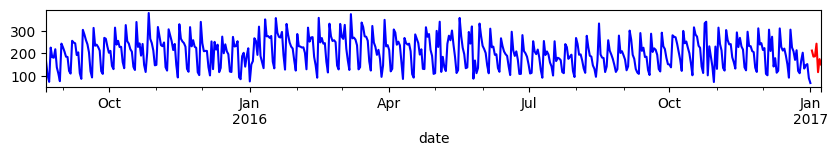

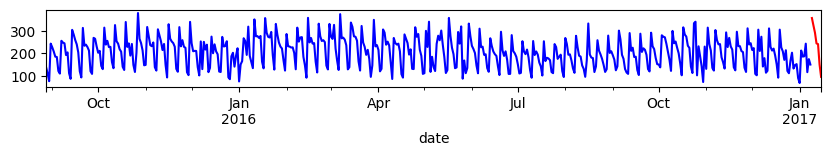

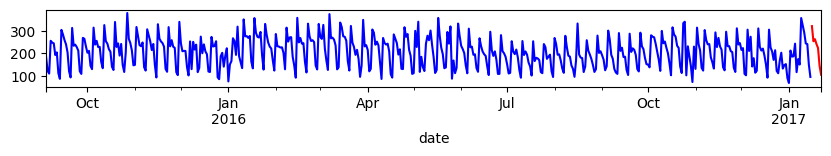

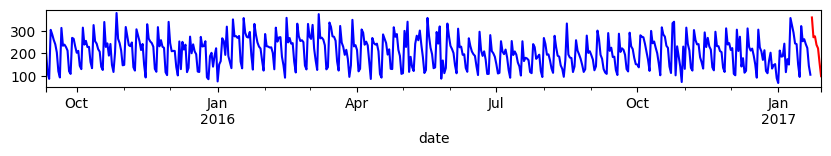

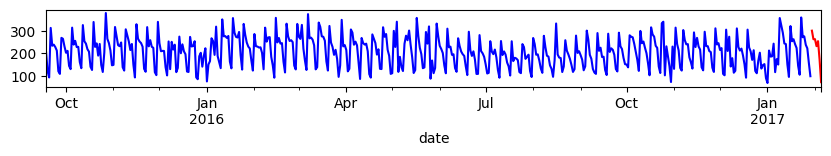

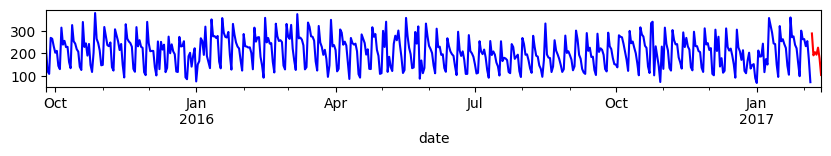

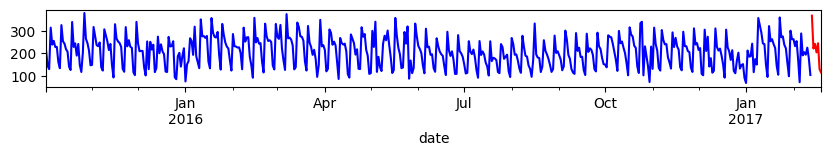

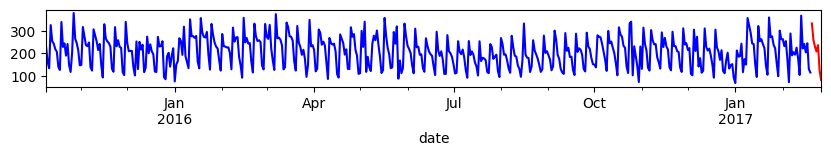

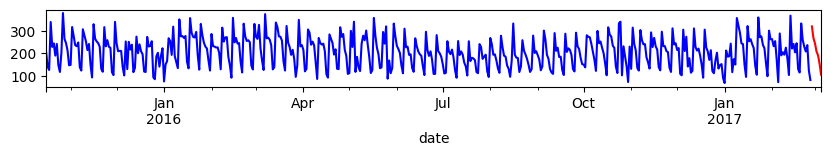

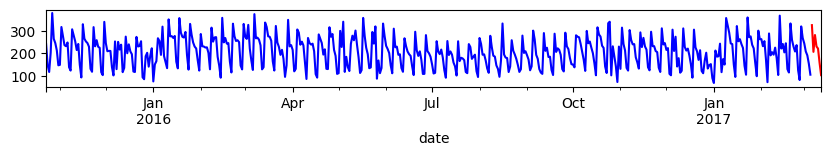

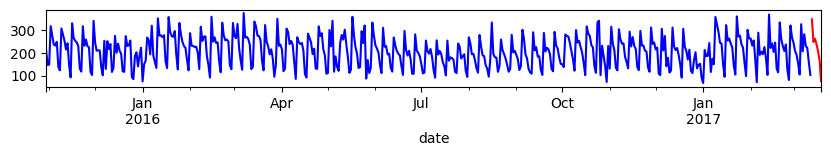

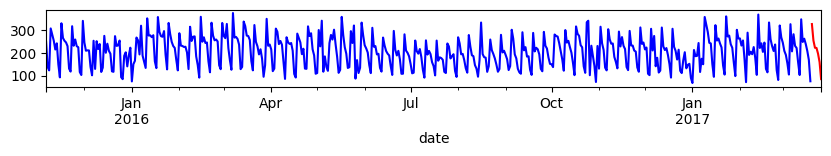

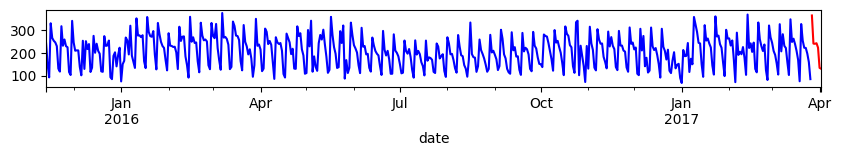

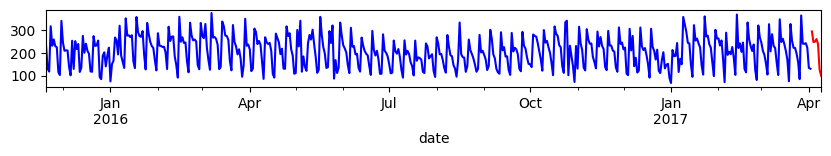

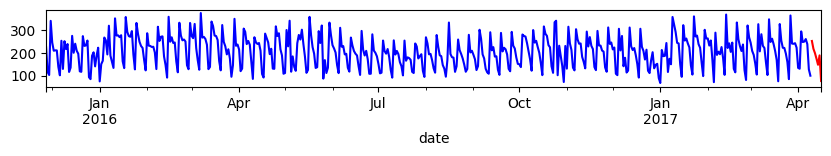

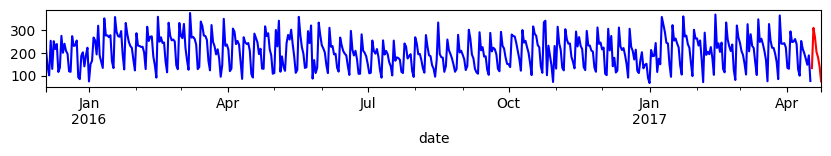

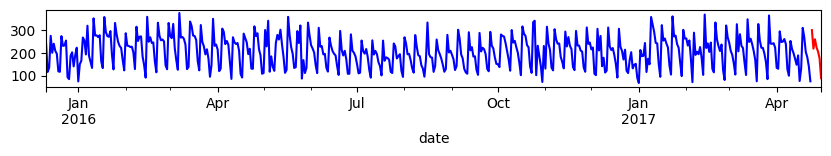

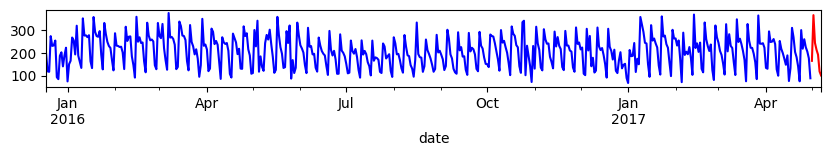

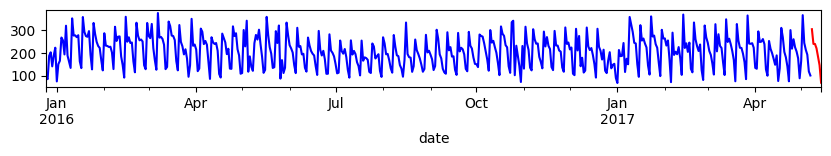

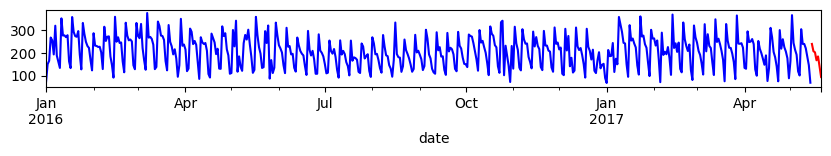

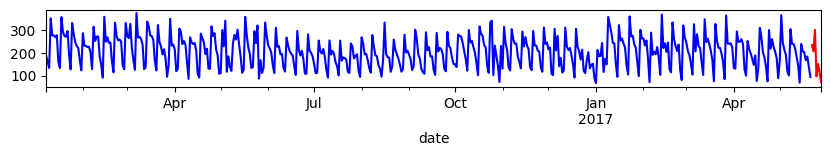

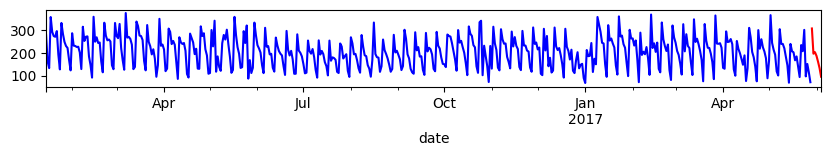

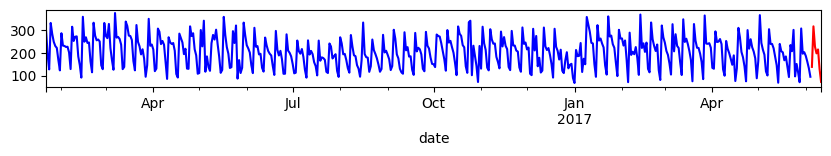

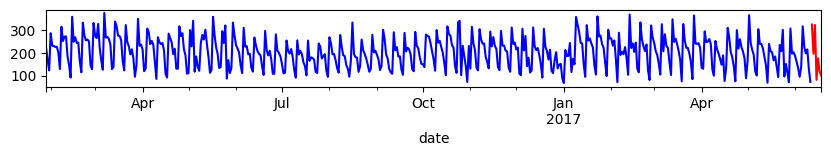

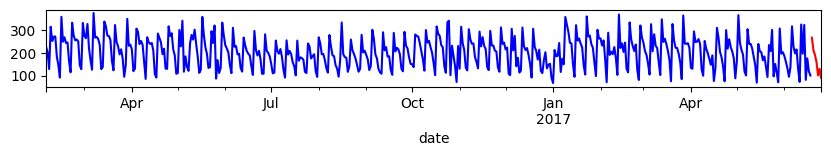

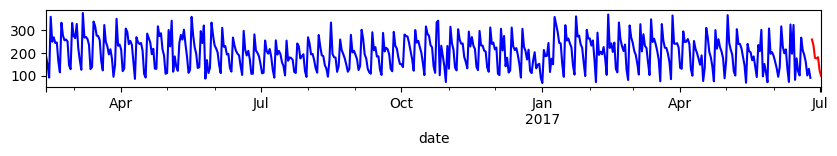

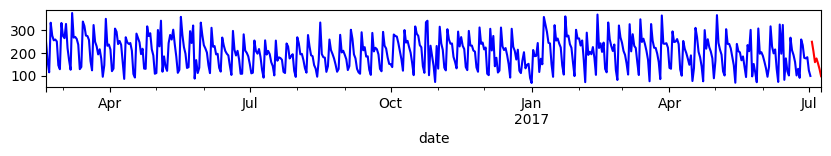

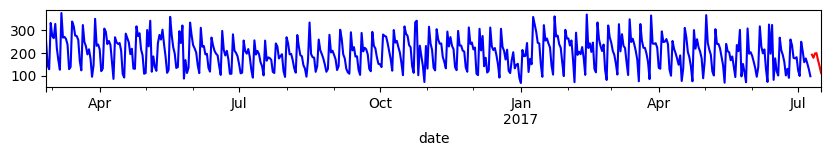

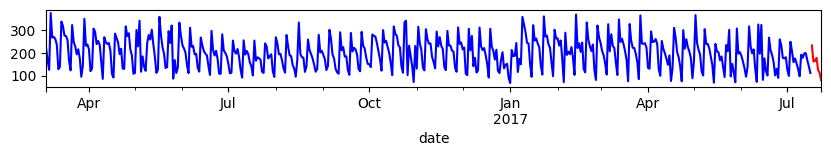

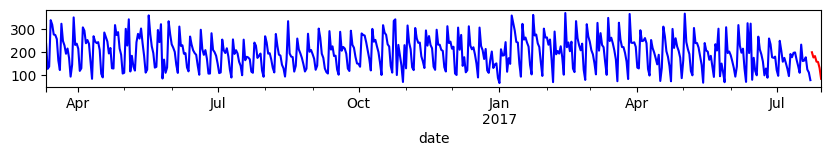

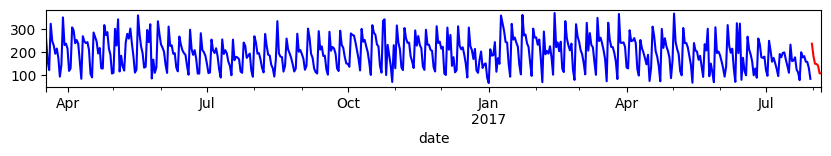

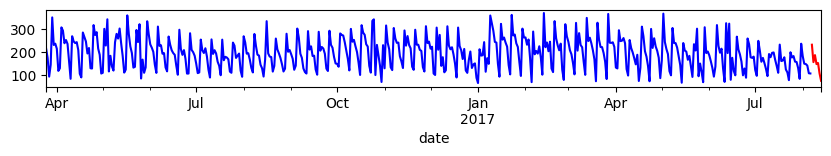

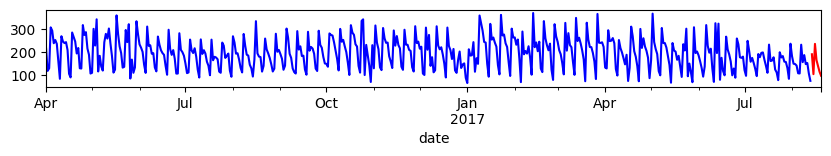

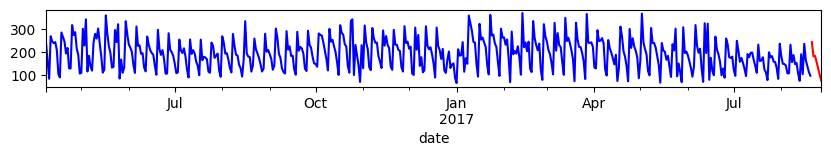

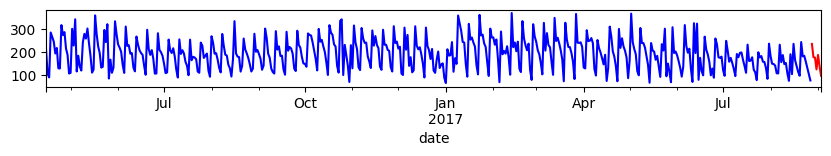

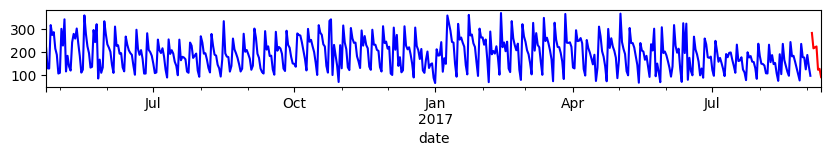

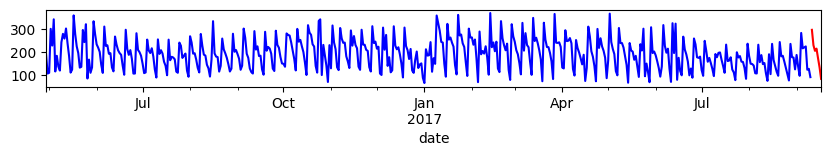

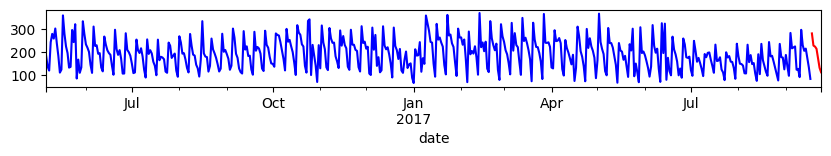

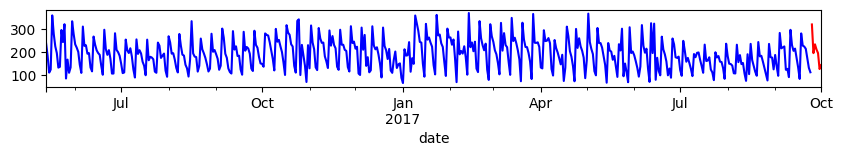

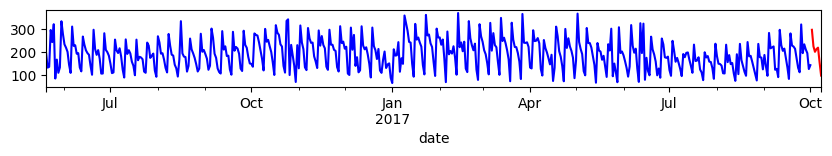

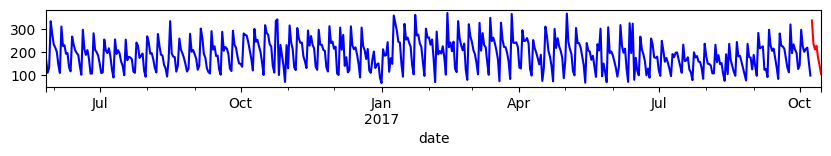

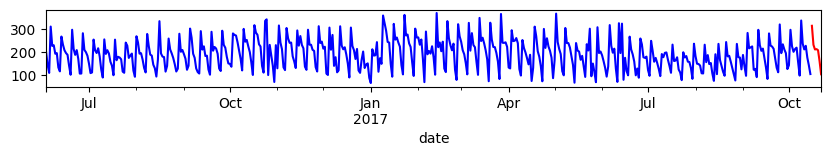

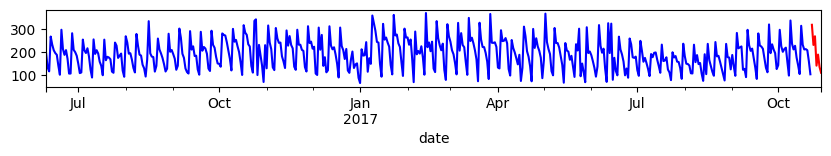

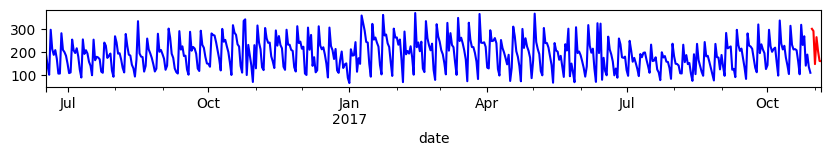

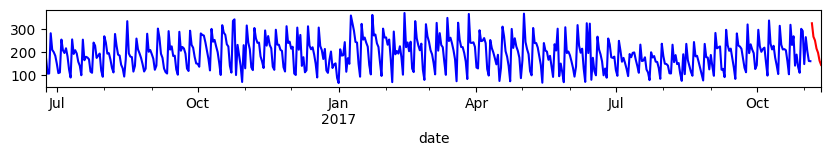

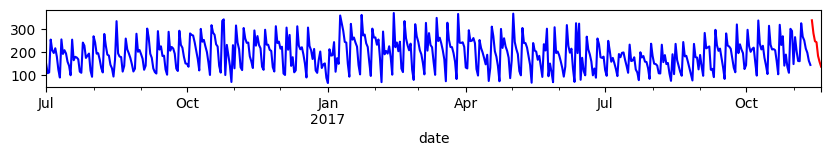

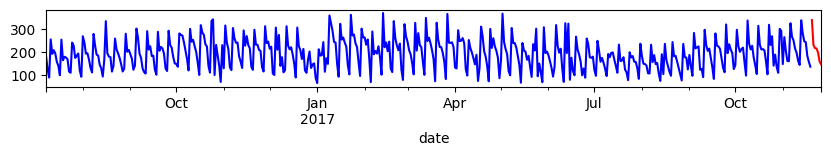

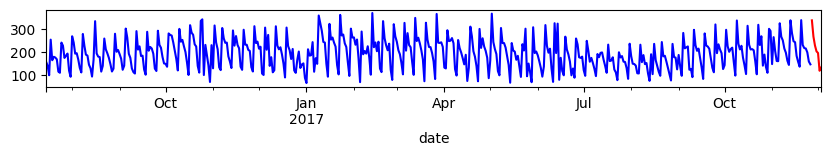

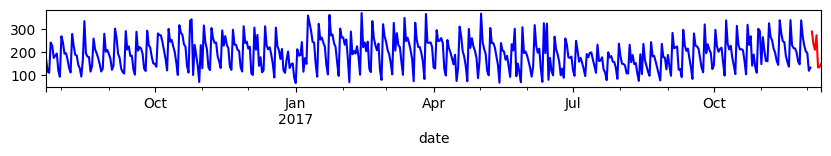

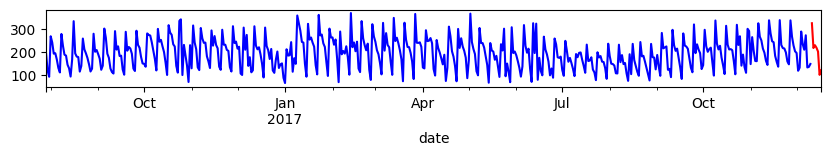

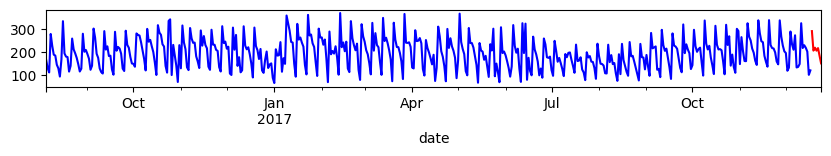

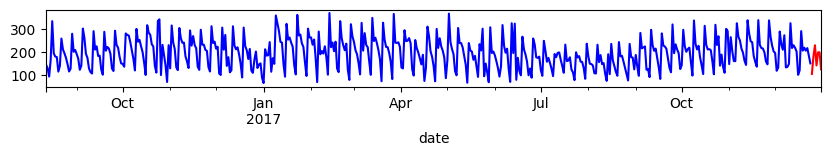

In [42]:
# extract an example time series for illustration purposes and perform TimeSeriesSplit
example_ts = df_train[(df_train['branch']=='Metro') & (df_train['product']=='Brown Bread')]['turnover']
tss = TimeSeriesSplit(n_splits=52, test_size=7, gap=0)

# plot repeated train-validation folds to get an idea of TimeSeriesSplit functionality
for train_i, val_i in tss.split(example_ts):
    ts_train = example_ts.iloc[train_i]
    ts_val = example_ts.iloc[val_i]

    plt.figure(figsize=(10, 1))
    ts_train[-500:].plot(c='blue', label='training')
    ts_val.plot(c='red', label='validation')
    plt.show()

### Naive Seasonal baseline
We will first define a utility function to perform cross-validation on naive seasonal baseline.

#### use sales 14 days ago if prediction contains missing from closed Center branch on public holidays
It is possible that a prediction for Naive Seasonal baseline includes values == 1 as prediction, which reflected NaN from public holidays in the preceding 7 day-interval used for prediction in case of Center branch.

In such as case, replace any NaN (currently encoded as 1) by the turnover day from exactly 7 days ago. Thus, in case a holiday is contained in the preceding week before prediction, any such holiday is replaced by sales data from the day of the preceding week. Thus, not the sales 7 days before before are used as a prediction when falling on a holiday, but instead the sales 14 days ago.

Similarly, it is possible that observations in the validation set contain NaNs. We will extract index positions for such events and then delete them from both validation set and predicted values before computing MAPE score.

In [43]:
# utility function for naive seasonal baseline corrected for holiday effects
def crossval_naive(df_train, grouping_vars, target, splits=52, test_size=7, gap=0):
    """Cross-Validation for Naive Seasonal Baseline:
    Takes in a training dataset of stacked time series and performs TimeSeriesSplit Cross-Validation for Naive Seasonal 
    baseline model for each of those time series. Returns a dataframe of cross-validation results containing mean MAPE scores 
    and corresponding standard deviations from cross-validation of each individual time series.

    Args:
        df_train (pd.DataFrame): A training dataframe containing stacked time series data
        grouping_vars (list): A list of grouping variables, according to which training data is stacked. Currently accepts only a list of two variables.
        target (str): Prediction target
        splits (int, optional): Number of splits for Cross-Validation. Defaults to 52 (1 fold / week).
        test_size (int, optional): Size of validation set (i.e. forecasting horizon). Defaults to 7 days.
        gap (int, optional): Time gap between end of training and start of validation set. Defaults to 0.

    Returns:
        pd.DataFrame: A dataframe with cross-validation results, containing mean MAPE scores and respective standard deviations for each time series
    """
    # initialize dataframe for evaluation scores
    cval = pd.DataFrame({'group': [], 'MAPE_mean': [], 'MAPE_std': []})

    # iterate over all individual series and perform cross-validation
    for i, group in enumerate(product(df_train[grouping_vars[0]].unique(), df_train[grouping_vars[1]].unique())):

        # subselect time series
        ts = df_train[(df_train[grouping_vars[0]]==group[0]) & (df_train[grouping_vars[1]]==group[1])].copy()
        
        # perform cross validation
        tss = TimeSeriesSplit(n_splits=splits, test_size=test_size, gap=gap)
        # initialize scores list for append MAPE scores from individual folds and start cross-validation
        scores = []
        for train_i, val_i in tss.split(ts):

            y_train = ts.iloc[train_i][target]
            y_val = ts.iloc[val_i][target]
            
            # correct for holiday effects in predicted values based on training set if necessary
            # if 1 (representing missing values on a holiday) is in prediced y-values, replace by sales 14 days ago
            if 1 in y_train[-7:].unique():
                idx_train = [i for i in range(len(y_train[-7:].tolist())) if y_train[-7:].tolist()[i]==1]
                idx_train = [i-7 for i in idx_train]
                idx_train_lag = [i-7 for i in idx_train]
                y_train_repl = y_train.copy()
                y_train_repl.iloc[idx_train] = [x for x in y_train.iloc[idx_train_lag]]
                y_pred = y_train_repl[-7:]
            else:
                y_pred = y_train[-7:]

            # correct for holiday effects in validation set if necessary
            # if 1 (representing missing values on a holiday) is in validation set, drop elements at corresponding index position in both y_val and y_pred
            if 1 in y_val.unique():
                idx_val = [i for i in range(len(y_val.tolist())) if y_val.tolist()[i]==1]
                y_val = y_val.drop(y_val.index[idx_val])
                y_pred = y_pred.drop(y_pred.index[idx_val])

            mape = mean_absolute_percentage_error(y_val, y_pred)
            scores.append(mape)
        
        # append mean MAPE scores and standart deviations overall all cross-validation folds per time series to dataframe
        cval.loc[i, 'group'] = f'{group[0]} | {group[1]}'
        cval.loc[i, 'MAPE_mean'] = np.mean(scores)
        cval.loc[i, 'MAPE_std'] = np.std(scores)
    # calculate mean scores over all time series
    cval.loc[i+1, 'group'] = 'mean'
    cval.loc[i+1, 'MAPE_mean'] = cval['MAPE_mean'].mean()
    cval.loc[i+1, 'MAPE_std'] = cval['MAPE_std'].mean()

    return cval

In [44]:
scores_naive = crossval_naive(df_train, grouping_vars=['branch', 'product'], target='turnover')

In [45]:
scores_naive

group  MAPE_mean  MAPE_std
0             Metro | Brown Bread   0.182581  0.098979
1             Metro | Wheat Rolls   0.124369  0.085053
2                   Metro | Cakes   0.178003  0.099431
3                Metro | Pastries   0.093057  0.070278
4           Metro | Savoury Snack   0.138022  0.153117
5            Center | Brown Bread   0.214138  0.120360
6            Center | Wheat Rolls   0.170992  0.079342
7                  Center | Cakes   0.264666  0.109093
8               Center | Pastries   0.164245  0.086210
9          Center | Savoury Snack   0.218662  0.131818
10    Train_Station | Brown Bread   0.188529  0.094343
11    Train_Station | Wheat Rolls   0.106944  0.062933
12          Train_Station | Cakes   0.256550  0.129893
13       Train_Station | Pastries   0.111564  0.049108
14  Train_Station | Savoury Snack   0.147559  0.145951
15                           mean   0.170659  0.101061

### LightGBM
We will iterate over every time series and evaluate LightGBM performance with only temporal and additional weather features using TimeSeriesSplit Cross-Validation.

First, we will define a utility function performing Cross-Validation.

In [46]:
# utility function for LightGBM
def crossval_lgbm(df_train, grouping_vars, target, features, lgbm_kwargs=None, splits=52, test_size=7, gap=0):
    """Cross-Validation for LightGBM model:
    Takes in a training dataset of stacked time series and performs TimeSeriesSplit Cross-Validation for LightGBM model 
    for each of those time series. Returns a dataframe of cross-validation results containing mean MAPE scores 
    and corresponding standard deviations from cross-validation of each individual time series.

    Args:
        df_train (pd.DataFrame): A training dataframe containing stacked time series data
        grouping_vars (list): A list of grouping variables, according to which training data is stacked. Currently accepts only a list of two variables.
        target (str): Prediction target
        features (list): List of feature names to be used for training the model
        lgbm_kwargs (dict, optional): Dictionary of LGBM hyperparameters. Defaults to None. If None, model is trained using default hyperparameters.
        splits (int, optional): Number of splits for Cross-Validation. Defaults to 52 (1 fold / week).
        test_size (int, optional): Size of validation set (i.e. forecasting horizon). Defaults to 7 days.
        gap (int, optional): Time gap between end of training and start of validation set. Defaults to 0.

    Returns:
        pd.DataFrame: A dataframe with cross-validation results, containing mean MAPE scores and respective standard deviations for each time series
    """
    # initialize dataframe for evaluation scores
    cval = pd.DataFrame({'group': [], 'MAPE_mean': [], 'MAPE_std': []})

    # iterate over all individual series and perform cross-validation
    from itertools import product
    for i, group in enumerate(product(df_train[grouping_vars[0]].unique(), df_train[grouping_vars[1]].unique())):

        # subselect time series
        ts = df_train[(df_train[grouping_vars[0]]==group[0]) & (df_train[grouping_vars[1]]==group[1])].copy()

        # perform cross validation
        tss = TimeSeriesSplit(n_splits=splits, test_size=test_size, gap=gap)
        # initialize scores list for append MAPE scores from individual folds and start cross-validation
        scores = []
        for train_i, val_i in tss.split(ts):

            train = ts.iloc[train_i]
            val = ts.iloc[val_i]

            # generate target and feature vectors
            X_train = train[features]
            X_val = val[features]
            y_train = train[target]
            y_val = val[target]

            # initialize model
            if lgbm_kwargs==None:
                lgbm = LGBMRegressor(objective='regression', random_state=42)
            else:
                lgbm = LGBMRegressor(objective='regression', random_state=42, **lgbm_kwargs)
            # train model
            lgbm.fit(X_train, y_train)
            # predict
            y_pred= pd.Series(lgbm.predict(X_val))

            # correct for holiday effects in validation set if necessary
            # if 1 (representing missing values on a holiday) is in validation set, drop elements at corresponding index position in both y_val and y_pred
            if 1 in y_val.unique():
                idx_val = [i for i in range(len(y_val.tolist())) if y_val.tolist()[i]==1]
                y_val = y_val.drop(y_val.index[idx_val])
                y_pred = y_pred.drop(y_pred.index[idx_val])

            mape = mean_absolute_percentage_error(y_val, y_pred)
            scores.append(mape)
        
        # append mean MAPE scores and standart deviations overall all cross-validation folds per time series to dataframe
        cval.loc[i, 'group'] = f'{group[0]} | {group[1]}'
        cval.loc[i, 'MAPE_mean'] = np.mean(scores)
        cval.loc[i, 'MAPE_std'] = np.std(scores)
    # calculate mean scores over all time series
    cval.loc[i+1, 'group'] = 'mean'
    cval.loc[i+1, 'MAPE_mean'] = cval['MAPE_mean'].mean()
    cval.loc[i+1, 'MAPE_std'] = cval['MAPE_std'].mean()
    
    return cval

In [47]:
df_train.columns

Index(['branch', 'product', 'turnover', 'year', 'month', 'week',
       'day_of_month', 'day_of_week', 'school_holiday', 'public_holiday',
       'lock', 'temp_mean', 'temp_min', 'temp_max', 'temp_std',
       'feels_like_mean', 'feels_like_min', 'feels_like_max', 'feels_like_std',
       'pressure_mean', 'pressure_min', 'pressure_max', 'pressure_std',
       'humidity_mean', 'humidity_min', 'humidity_max', 'humidity_std',
       'clouds_mean', 'clouds_min', 'clouds_max', 'clouds_std',
       'wind_speed_mean', 'wind_speed_min', 'wind_speed_max', 'wind_speed_std',
       'wind_dir_x_mean', 'wind_dir_x_min', 'wind_dir_x_max', 'wind_dir_x_std',
       'wind_dir_y_mean', 'wind_dir_y_min', 'wind_dir_y_max', 'wind_dir_y_std',
       'rain_1h_mean', 'rain_1h_min', 'rain_1h_max', 'rain_1h_std',
       'snow_1h_mean', 'snow_1h_min', 'snow_1h_max', 'snow_1h_std',
       'visibility_mean', 'visibility_min', 'visibility_max', 'visibility_std',
       'condition_total', 'clear_total', 'cloudy_tota

In [50]:
# define features and hyperparameters based on previous gridsearch results
lgbm_features = ['turnover_lag_7', 'turnover_lag_365', 
                    'month_sin', 'month_cos', 'day_of_week', 'school_holiday', 'public_holiday',
                    'feels_like_mean', 'humidity_mean', 'rain_1h_mean', 'snow_1h_mean',
                    'feels_like_mean_dev', 'pressure_mean_dev', 'humidity_mean_dev',
                    'temp_mean_change', 'pressure_mean_change', 'humidity_mean_change',
                    'temp_mean_lead_1', 'rain_1h_mean_lead_1', 'snow_1h_mean_lead_1',
                    'day_frosty', 'day_thunder', 'day_clear','day_hazy', 'day_summer','day_murky'
                    ]

params_optimal = {
    'boosting_type': 'dart',
    'n_estimators': 100,
    'learning_rate': 0.1
}

In [51]:
scores_lgbm = crossval_lgbm(df_train, grouping_vars=['branch', 'product'], target='turnover', features=lgbm_features,
                            lgbm_kwargs=params_optimal)

In [52]:
scores_lgbm

group  MAPE_mean  MAPE_std
0             Metro | Brown Bread   0.127243  0.055078
1             Metro | Wheat Rolls   0.080300  0.034599
2                   Metro | Cakes   0.134402  0.064853
3                Metro | Pastries   0.088357  0.038512
4           Metro | Savoury Snack   0.095231  0.071282
5            Center | Brown Bread   0.195957  0.133326
6            Center | Wheat Rolls   0.123226  0.054963
7                  Center | Cakes   0.193662  0.088956
8               Center | Pastries   0.128269  0.064318
9          Center | Savoury Snack   0.199764  0.109869
10    Train_Station | Brown Bread   0.186268  0.100496
11    Train_Station | Wheat Rolls   0.111468  0.043324
12          Train_Station | Cakes   0.206772  0.127579
13       Train_Station | Pastries   0.107421  0.031934
14  Train_Station | Savoury Snack   0.140436  0.127443
15                           mean   0.141252  0.076436

In [53]:
# save cross-validation results
scores_naive.to_csv('../models/lgbm_optimized/CV_naive_baseline.csv', index=False)
scores_lgbm.to_csv('../models/lgbm_optimized/CV_lgbm_optimized.csv', index=False)

In [54]:
scores_merged = scores_naive.merge(scores_lgbm, on='group', suffixes=['_naive', '_lgbm'])

In [55]:
scores_grouped = pd.DataFrame(scores_merged[['group', 'MAPE_mean_naive', 'MAPE_mean_lgbm']].set_index('group').stack().reset_index().iloc[:-2, :])
scores_grouped.columns = ['group', 'model', 'MAPE_mean']
scores_grouped['MAPE_std'] = pd.DataFrame(scores_merged[['group', 'MAPE_std_naive', 'MAPE_std_lgbm']].set_index('group').stack().reset_index().iloc[:-2, :])[0]
scores_grouped['model'] = [x.split('_')[-1] for x in scores_grouped['model']]
scores_grouped[['MAPE_mean', 'MAPE_std']] = scores_grouped[['MAPE_mean', 'MAPE_std']] *100

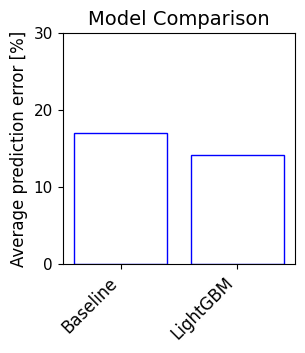

In [56]:
plt.figure(figsize=(3,3))
sns.barplot(data=scores_grouped, x='model', y='MAPE_mean', color='white', edgecolor='blue', errwidth=0)
plt.ylabel('Average prediction error [%]', fontsize=12)
plt.yticks(np.arange(0, 31, 10), fontsize=11)
plt.xlabel(None)
plt.xticks(ticks=np.arange(0, 2), labels=['Baseline', 'LightGBM'], fontsize=12, rotation=45, ha='right');
plt.title('Model Comparison', fontsize=14)
plt.show()

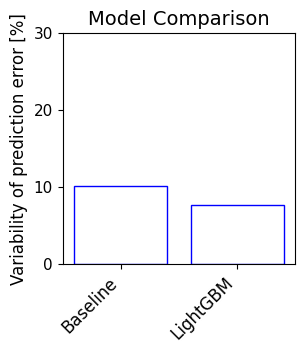

In [57]:
plt.figure(figsize=(3,3))
sns.barplot(data=scores_grouped, x='model', y='MAPE_std', color='white', edgecolor='blue', errwidth=0)
plt.ylabel('Variability of prediction error [%]', fontsize=12)
plt.yticks(np.arange(0, 31, 10), fontsize=11)
plt.xlabel(None)
plt.xticks(ticks=np.arange(0, 2), labels=['Baseline', 'LightGBM'], fontsize=12, rotation=45, ha='right');
plt.title('Model Comparison', fontsize=14)
plt.show()

### calculate feature importance for optimized LGBM model

In [58]:
def get_lgbm_feature_importance(df_train, grouping_vars, target, features, lgbm_kwargs=None, filepath=None):
    """Extracting feature importance from LightGBM model:
    Trains separate LightGBM models for individual time series in a stacked time series training dataframe and extracts feature importances.
    Returns dataframe containing feature importances for each individual time series. 

    Args:
        df_train (pd.DataFrame): A training dataframe containing stacked time series data
        grouping_vars (list): A list of grouping variables, according to which training data is stacked. Currently accepts only a list of two variables.
        target (str): Prediction target
        features (list): List of feature names to be used for training the model
        lgbm_kwargs (dict, optional): Dictionary of LGBM hyperparameters. Defaults to None. If None, model is trained using default hyperparameters.
        filepath (str, optional): File path for saving trained model. Defaults to None.

    Returns:
        pd.DataFrame: a dataframe containing feature importances for all indivudal time series.
    """
    # initialize empty dataframe with group column and feature columns
    fimportance = pd.DataFrame({}, columns=['group']+features)

    # iterate over all individual series and fit LightGBM model
    for i, group in enumerate(product(df_train[grouping_vars[0]].unique(), df_train[grouping_vars[1]].unique())):

        # subselect time series
        ts_train = df_train[(df_train[grouping_vars[0]]==group[0]) & (df_train[grouping_vars[1]]==group[1])].copy()


        X_train = ts_train[features]
        y_train = ts_train[target]

        if lgbm_kwargs!=None:
            lgbm = LGBMRegressor(objective='regression', random_state=42, importance_type='gain', **lgbm_kwargs)
        else:
            lgbm = LGBMRegressor(objective='regression', random_state=42, importance_type='gain')
        
        # train model
        lgbm.fit(X_train, y_train)
        
        # save model if filepath specified
        if filepath != None:
            lgbm.booster_.save_model(filename=os.path.join(filepath, f'lgbm_{group[0]}_{group[1]}.txt'))

        # append feature importances per time series to dataframe
        fimportance.loc[i, 'group'] = f'{group[0]} | {group[1]}'
        fimportance.loc[i, fimportance.columns[1:]] = lgbm.feature_importances_.tolist()
    # calculate mean feature importance averaged over all individual time series
    fimportance.loc[i+1, 'group'] = 'mean'
    fimportance.loc[i+1, fimportance.columns[1:]] = [fimportance[x].mean() for x in fimportance.columns[1:]]

    return fimportance

In [59]:
directory = '../models/lgbm_optimized/trained_models/'
#os.mkdir(directory)

In [61]:
lgbm_fimportance = get_lgbm_feature_importance(df_train, grouping_vars=['branch', 'product'], target='turnover', features=lgbm_features,
                            lgbm_kwargs=params_optimal, filepath=directory)

In [62]:
lgbm_fimportance

group     turnover_lag_7  turnover_lag_365  \
0             Metro | Brown Bread    78166637.098877    6175688.508057   
1             Metro | Wheat Rolls    14936497.865234    2122118.137207   
2                   Metro | Cakes   204893374.586914   14094557.186523   
3                Metro | Pastries  1083085441.507812   73148199.398438   
4           Metro | Savoury Snack       1140929326.5  135413106.601562   
5            Center | Brown Bread    75017954.105957    13169376.23877   
6            Center | Wheat Rolls     3241565.869385    1742996.729309   
7                  Center | Cakes    71994819.974609   23901791.554688   
8               Center | Pastries   491880674.958984   33541388.380859   
9          Center | Savoury Snack     6869051.852539    1038150.726074   
10    Train_Station | Brown Bread    36412117.588623      3096373.5896   
11    Train_Station | Wheat Rolls    38757477.895996    1176973.075928   
12          Train_Station | Cakes    57937494.280762    3239264.497559   
13       Train_Station | Pastries   401872520.974609   17539189.520508   
14  Train_Station | Savoury Snack  3245430505.003906   52232382.886719   
15                           mean   463428364.004281    25442103.80212   

          month_sin         month_cos       day_of_week   school_holiday  \
0    1449442.108643     981796.130371   18342452.256836   2195947.410889   
1      701849.61084    4208733.906494   131617177.90918   4548056.400879   
2    3513030.603516     9574476.71875   12651419.478516    4670581.40918   
3   27480830.011719   56163114.203125  112202150.605469  29343852.207031   
4        24623427.5  108771001.601562      4396866196.0       59277304.0   
5     880980.779297    1706269.612793    9988875.700684   1357570.099121   
6      506262.25592      86200.260742    33280344.67749   2968935.404724   
7    3578790.916992   12443167.683594  304627386.920898  13055018.845703   
8   19837150.533203   10163905.789062   87148374.645508   7244074.111328   
9     688138.383057    4305294.086426     4078135.07373    4514600.63208   
10    369296.019287     328962.798828    8457786.035156    261901.621338   
11    497315.299561     370621.267944     964728.171509    124551.758789   
12   1677599.859375    2585436.970215   11735860.787598    238346.297852   
13   6846293.197266    8117797.988281   21415543.316406   2618491.603516   
14  15426483.507812    20235900.28125   79141873.675781  12983440.804688   
15   7205126.039099   16002845.286629  348834553.683651   9693511.507141   

     public_holiday  feels_like_mean    humidity_mean  ...  \
0    4308383.978516   1941268.559082    839817.517578  ...   
1    14341290.27124    1398510.94043    874894.680664  ...   
2    8064265.517578   8262001.305664   3600923.001953  ...   
3    12257612.90625  59423926.214844   6028265.902344  ...   
4       668858116.0       53176706.0       16028847.5  ...   
5   23129312.799805   1551062.001465   1785216.613281  ...   
6    3364017.318604    764865.398743     173666.07312  ...   
7   24492359.201172  15026107.297852   5915720.901367  ...   
8   36373413.390625  10038176.030273   3026857.907227  ...   
9   10714081.851562   4851489.511719   1269735.581055  ...   
10    3665834.77002   1445768.146606   1024343.718994  ...   
11     61265.329834    573686.310547    460389.098389  ...   
12  12595486.889648   5203882.042969   2255173.081543  ...   
13  20444136.414062  13054627.394531   3528061.408203  ...   
14  33351510.402344       10504078.0  17616453.902344  ...   
15  58401405.802751  12481077.010315   4295224.459204  ...   

   humidity_mean_change temp_mean_lead_1 rain_1h_mean_lead_1  \
0         350773.830566   1550462.192383       203045.209473   
1         488267.932373    1412675.58667       261417.599854   
2        1658226.292969   3639740.793945      1401845.808594   
3        5441291.617188  10017378.007812      1488423.691406   
4            12925425.0       43892878.0           9752720.0   
5        1236053.279297   2525431.783

In [63]:
lgbm_fimportance.to_csv('../models/lgbm_optimized/feature_importance.csv', index=False)

In [64]:
# calculate feature importance by gain in percent relative to total gain for that time series
lgbm_fimportance_rel = lgbm_fimportance.copy()
lgbm_fimportance_rel['sum'] = lgbm_fimportance_rel[lgbm_fimportance_rel.columns[1:]].sum(axis=1)

lgbm_fimportance_rel[lgbm_fimportance_rel.columns[1:]] = lgbm_fimportance_rel[lgbm_fimportance_rel.columns[1:]].div(lgbm_fimportance_rel['sum'], axis=0) * 100
lgbm_fimportance_rel.drop(columns=['sum'], inplace=True)

In [65]:
lgbm_fi_stacked = lgbm_fimportance_rel.set_index('group').stack().reset_index()
lgbm_fi_stacked.columns = ['group', 'features', 'importance']

In [66]:
col_order = lgbm_fimportance_rel.set_index('group').sort_values(by='mean', axis=1, ascending=False).columns
col_order

Index(['turnover_lag_7', 'day_of_week', 'public_holiday', 'turnover_lag_365',
       'month_cos', 'feels_like_mean', 'school_holiday', 'temp_mean_lead_1',
       'feels_like_mean_dev', 'month_sin', 'humidity_mean_dev',
       'pressure_mean_dev', 'temp_mean_change', 'humidity_mean',
       'pressure_mean_change', 'humidity_mean_change', 'rain_1h_mean',
       'rain_1h_mean_lead_1', 'day_hazy', 'day_summer', 'snow_1h_mean_lead_1',
       'day_frosty', 'day_clear', 'day_murky', 'snow_1h_mean', 'day_thunder'],
      dtype='object')

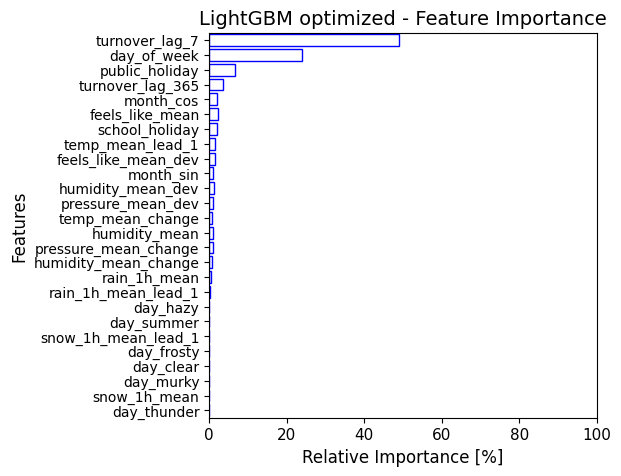

In [67]:
plt.figure(figsize=(5, 5))
sns.barplot(data=lgbm_fi_stacked, y='features', x='importance', color='white', edgecolor='blue', errwidth=0, order=col_order)
plt.xlabel('Relative Importance [%]', fontsize=12)
plt.xticks(ticks=np.arange(0, 101, 20), labels=np.arange(0, 101, 20), fontsize=11)
plt.ylabel('Features', fontsize=12)
plt.title('LightGBM optimized - Feature Importance', fontsize=14)
plt.show()


### predict new cases
Here, we will generate predictions for the test set. First, we will define a utility function to perform predictions on the test set for defined time window (restricted to 7 days).

In [68]:
# utility function for predicting y-values using LightGBM for specified time window
def LGBM_predict(df_train, df_test, grouping_vars, target, features, lgbm_kwargs, start_date, end_date, compute_shap=False, plot=False, show_baseline=False):
    """Predict target values using LightGBM for defined time window:
    Fits a LightGBM model to each individual time series and generates a prediction based on a specified time window in the test dataset.
    Can accept any time window length specified by start_date and end_date. However, it is highly recommended to set the prediction time window 
    to a maximum of 7 days. Also computes shap values and plots prediction results for specified time window if specified.

    Args:
        df_train (pd.DataFrame): A training dataframe containing stacked time series data
        df_test (pd.DataFrame): A test dataframe containing stacked time series data
        grouping_vars (list): A list of grouping variables, according to which training data is stacked. Currently accepts only a list of two variables.
        target (str): Prediction target
        features (list): List of feature names to be used for training the model
        lgbm_kwargs (dict, optional): Dictionary of LGBM hyperparameters. Defaults to None. If None, model is trained using default hyperparameters.
        start_date (str): Start date of prediction time window
        end_date (str): End date of prediction time window
        compute_shap (bool, optional): Compute shap values for each prediction. Defaults to False.
        plot (bool, optional): Display time series plots for observed and predicted values. Defaults to False.
        show_baseline (bool, optional): Include predictions by Seasonal Naive baseline in time series plots. Defaults to False.

    Returns:
        dict: Dictionary containg predicted y-values (y_pred), observed y-values (y_true), MAPE scores and shap values associated with
        the predictions for each individual time series.
    """
    # initialize dataframe for evaluation scores
    preds = {'group': [], 'y_pred': [], 'y_true': [], 'MAPE': [], 'shap': []}

    # iterate over all individual series
    for i, group in enumerate(product(df_test[grouping_vars[0]].unique(), df_test[grouping_vars[1]].unique())):

        # subselect time series for train and test
        ts_test = df_test[(df_test[grouping_vars[0]]==group[0]) & (df_test[grouping_vars[1]]==group[1])].copy()
        ts_train = df_train[(df_train[grouping_vars[0]]==group[0]) & (df_train[grouping_vars[1]]==group[1])].copy()
        
        # generate target and feature vectors
        X_train = ts_train[features]
        X_test = ts_test[features]
        y_train = ts_train[target]
        y_test = ts_test[target]

        # initialize model
        if lgbm_kwargs==None:
            lgbm = LGBMRegressor(objective='regression', random_state=42)
        else:
            lgbm = LGBMRegressor(objective='regression', random_state=42, **lgbm_kwargs)
        # fit model to train data
        lgbm.fit(X_train, y_train)

        # extract 7d prediction sample and predict
        y_test_sample = y_test[(y_test.index >= pd.to_datetime(start_date)) & (y_test.index <= pd.to_datetime(end_date))]
        X_test_sample = X_test[(X_test.index >= pd.to_datetime(start_date)) & (X_test.index <= pd.to_datetime(end_date))]
        y_pred = pd.Series(lgbm.predict(X_test_sample))

        # also extract prediction from naive baseline to show for comparison if required
        y_pred_naive = X_test_sample['turnover_lag_7'].fillna(1)
        # correct for holiday effects; if holiday is in prediced y-values, replace by sales 14 days ago
        if 1 in y_pred_naive.unique():
            idx_naive = [i for i in range(len(y_pred_naive.tolist())) if y_pred_naive.tolist()[i]==1]
            idx_naive = [i-7 for i in idx_naive]
            idx_naive_lag = [i-7 for i in idx_naive]
            y_pred_naive = X_test.loc[(X_test.index <= pd.to_datetime(end_date)), 'turnover_lag_7']
            y_pred_naive.iloc[idx_naive] = [x for x in y_train.iloc[idx_naive_lag]]
            y_pred_naive = y_pred_naive[-7:]
        
        # correct for holiday effects in validation set if necessary
        # if holiday is in validation set, drop elements at corresponding index position in both y_test and y_pred
        if 1 in y_test_sample.unique():
            idx_test = [i for i in range(len(y_test_sample.tolist())) if y_test_sample.tolist()[i]==1]
            y_test_sample = y_test_sample.drop(y_test_sample.index[idx_test])
            y_pred = y_pred.drop(y_pred.index[idx_test])
            y_pred_naive = y_pred_naive.drop(y_pred_naive.index[idx_test])

        # compute MAPE
        mape = mean_absolute_percentage_error(y_test_sample, y_pred)

        # append results
        preds['group'].append(f'{group[0]} | {group[1]}')
        preds['y_pred'].append([y_pred])
        preds['y_true'].append([y_test_sample])
        preds['MAPE'].append(mape)

        # compute shap values
        if compute_shap==True:
            explainer = shap.Explainer(lgbm)
            shap_values = explainer(X_test_sample)
            preds['shap'].append(shap_values)
        
        # plot prediction results over observed values
        if plot==True:
            sample_data = y_test_sample.reset_index()
            sample_data['y_pred_LGBM'] = y_pred.values
            sample_data['y_pred_naive'] = y_pred_naive.values
            sample_data.columns = ['date', 'observed', 'y_pred_LGBM', 'y_pred_naive']
            
            plt.figure(figsize=(6, 2))
            sns.lineplot(data=sample_data, x='date', y='observed', color='black')
            # plot also baseline predictions for reference if required
            if show_baseline==True:
                sns.lineplot(data=sample_data, x='date', y='y_pred_naive', color='red', marker='o')
            sns.lineplot(data=sample_data, x='date', y='y_pred_LGBM', color='blue', marker='o')
            plt.ylabel('Turnover [€]', fontsize=12)
            plt.yticks(fontsize=12)
            plt.ylim(0, np.max(sample_data['observed'])+100)
            plt.xlabel(None)
            plt.xticks(rotation=45, ha='right', fontsize=11)
            if show_baseline==True:
                plt.legend(labels=['observed', 'predicted by baseline', 'predicted by LGBM'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
            else:
                plt.legend(labels=['observed', 'predicted'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
            plt.title(f'{group[0]} | {group[1]}\n{start_date} - {end_date}', fontsize=14)
            plt.show()

    return preds

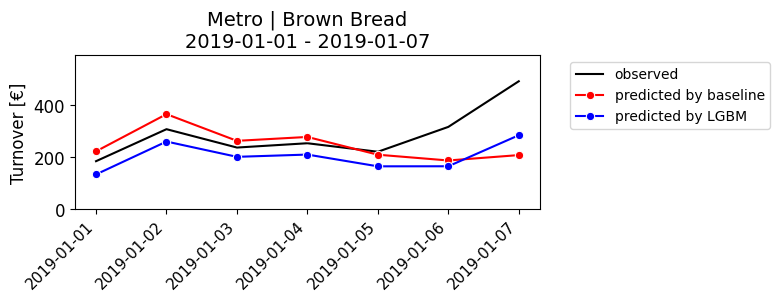

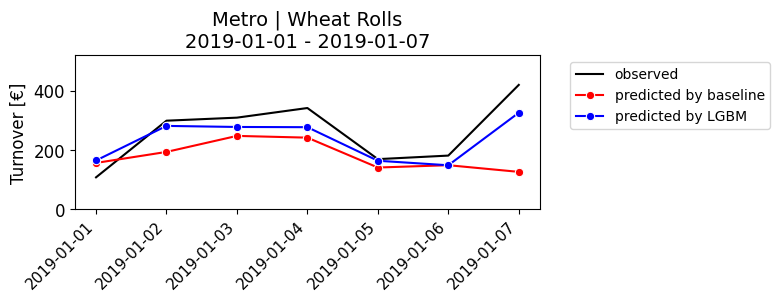

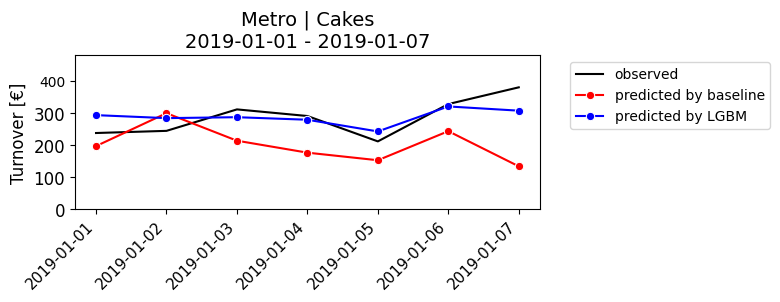

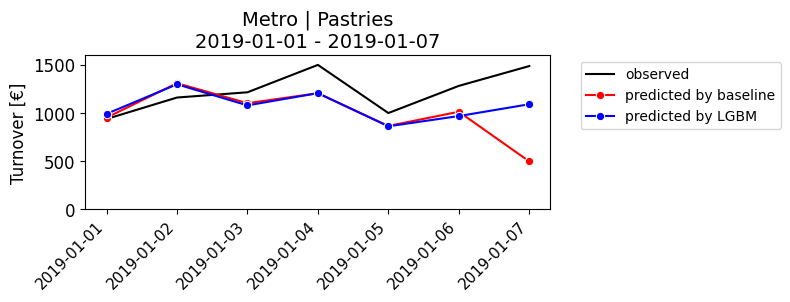

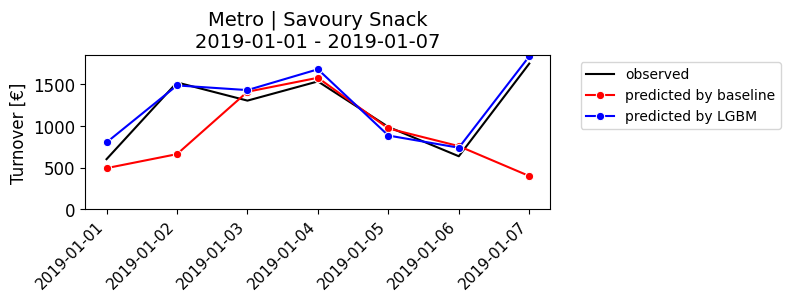

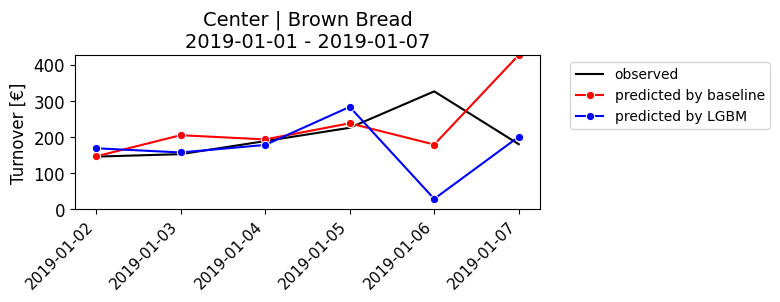

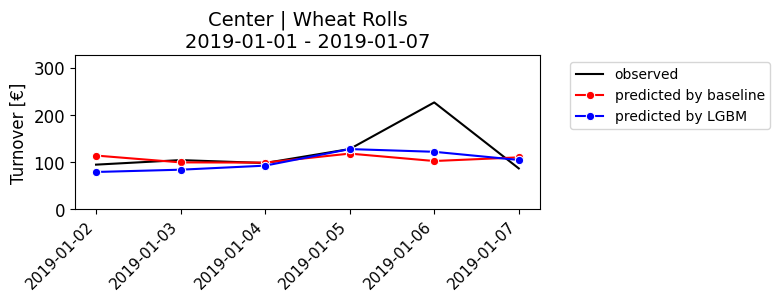

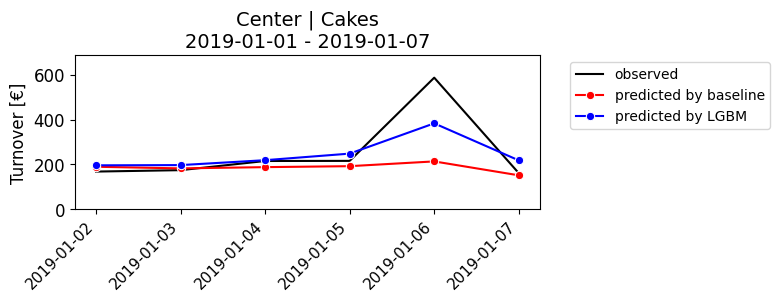

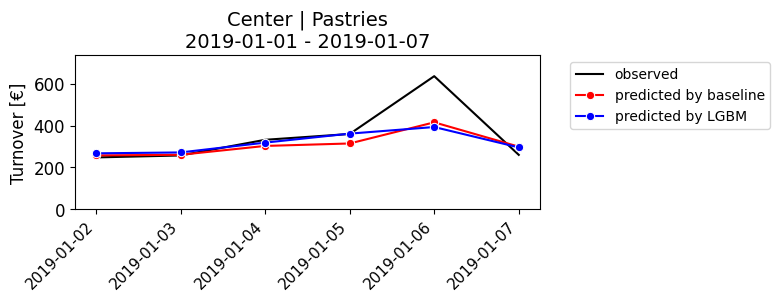

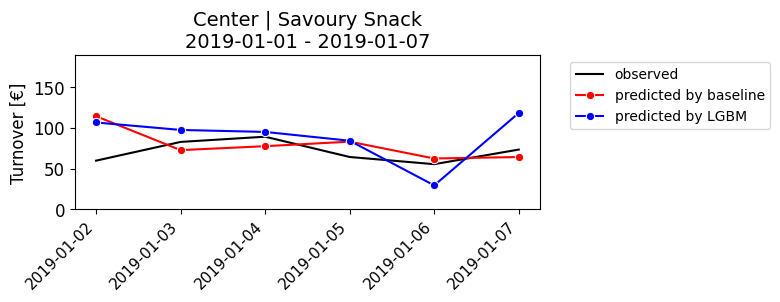

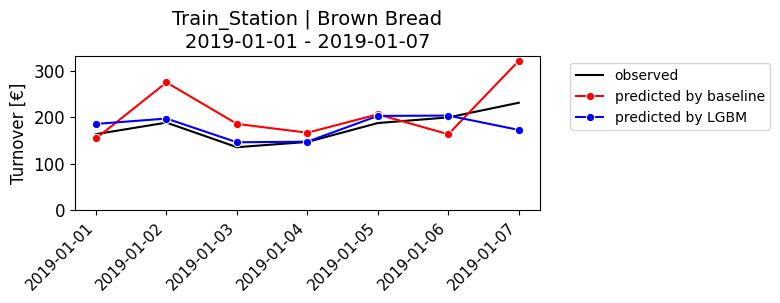

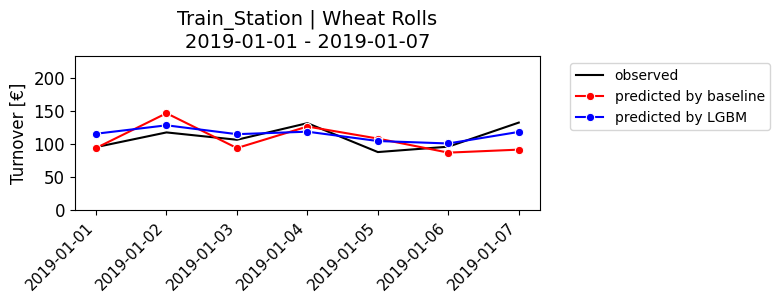

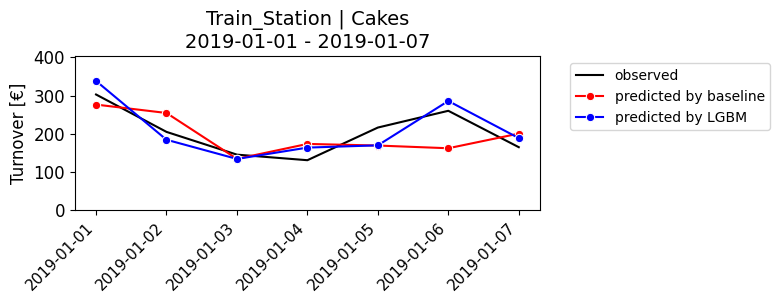

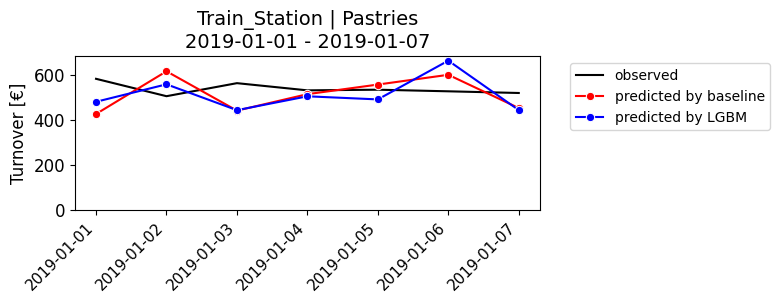

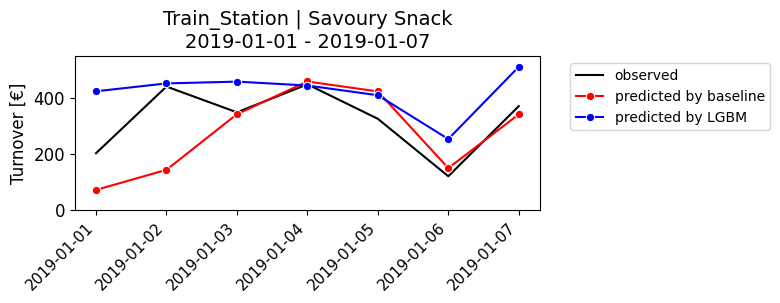

In [69]:
lgbm_preds = LGBM_predict(df_train, df_test, grouping_vars=['branch', 'product'], target='turnover', features=lgbm_features, 
                    lgbm_kwargs=params_optimal, start_date='2019-01-01', end_date='2019-01-07', compute_shap=True, plot=True, show_baseline=True)

### generate shap values plots

Metro | Brown Bread


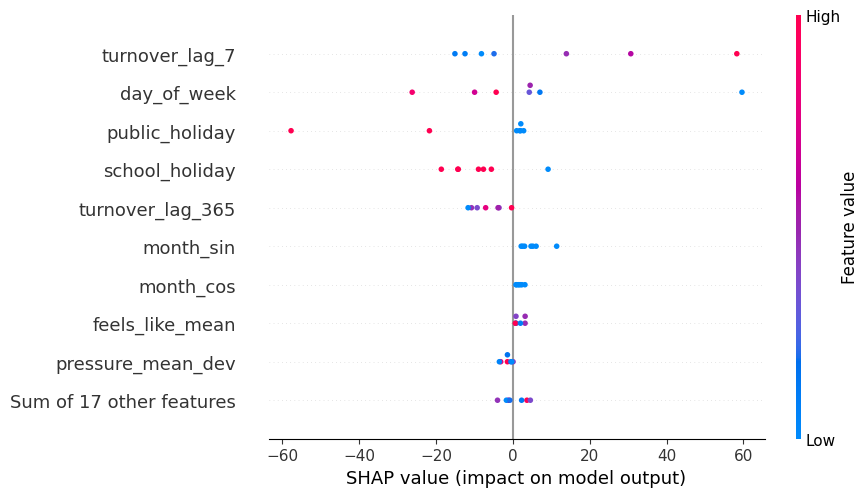

Metro | Wheat Rolls


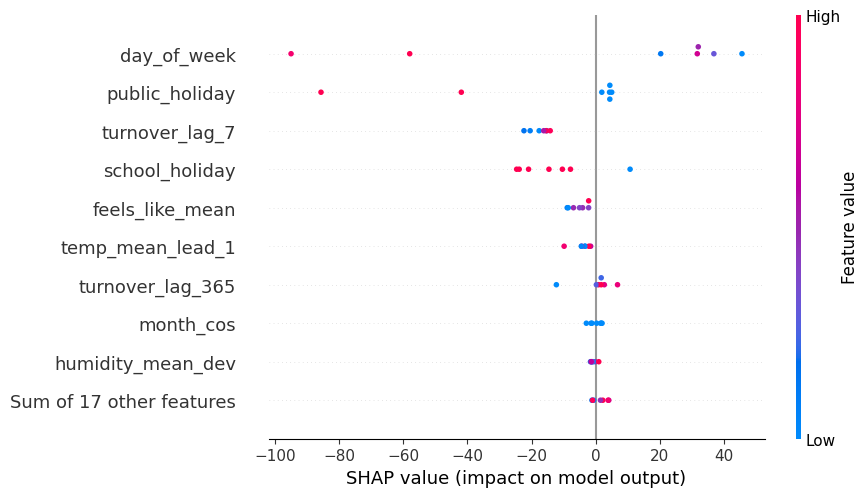

Metro | Cakes


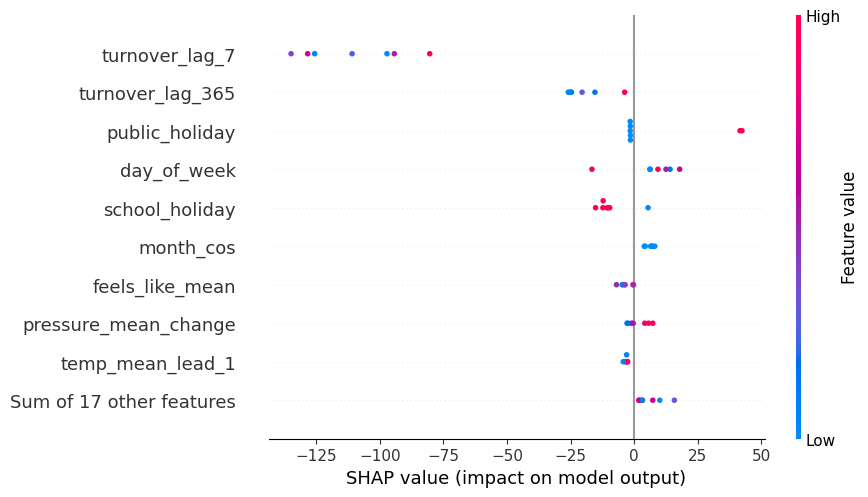

Metro | Pastries


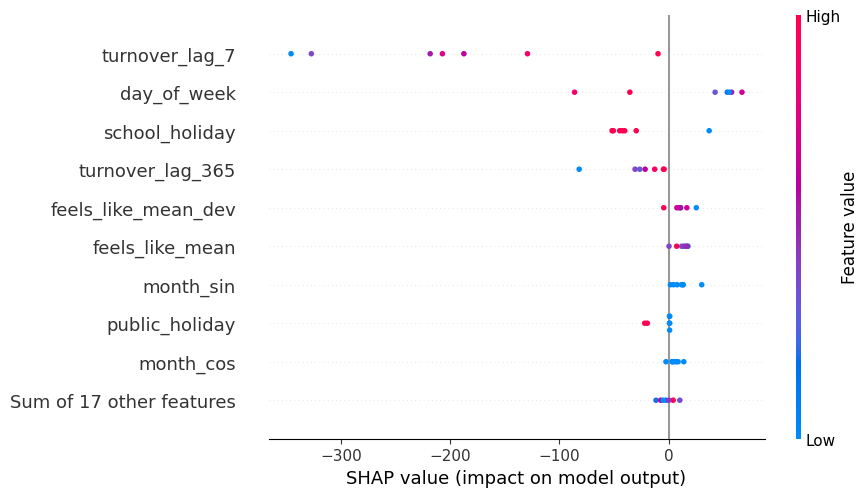

Metro | Savoury Snack


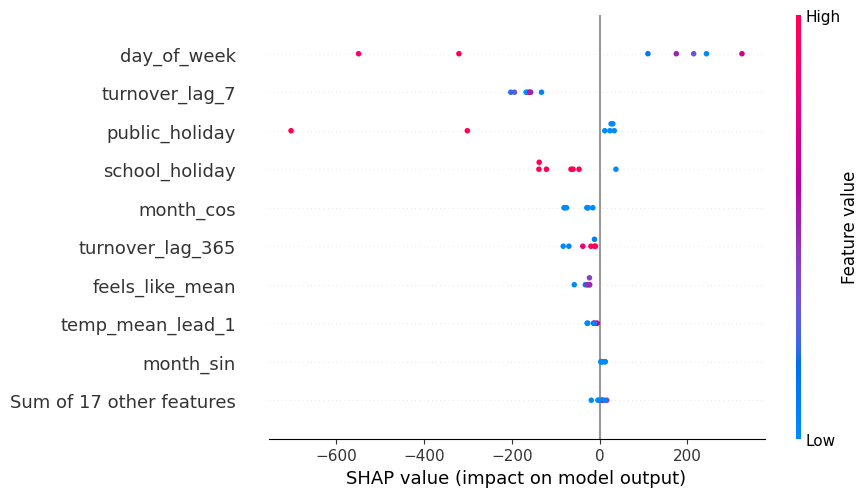

Center | Brown Bread


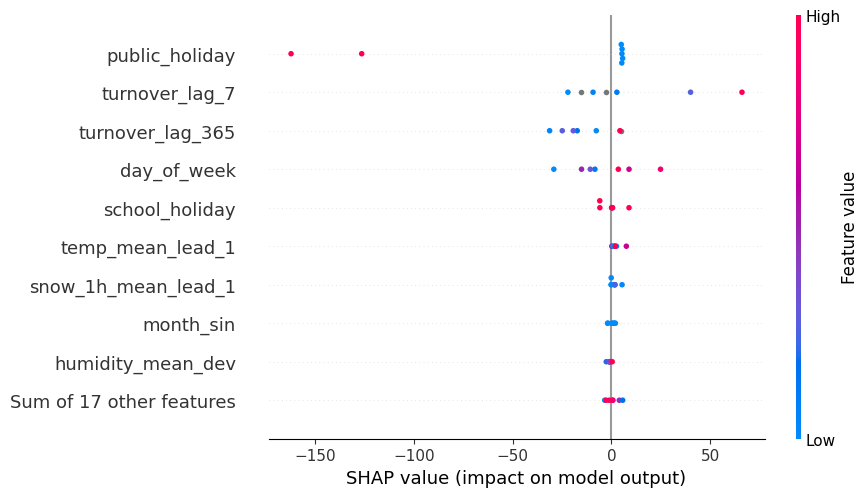

Center | Wheat Rolls


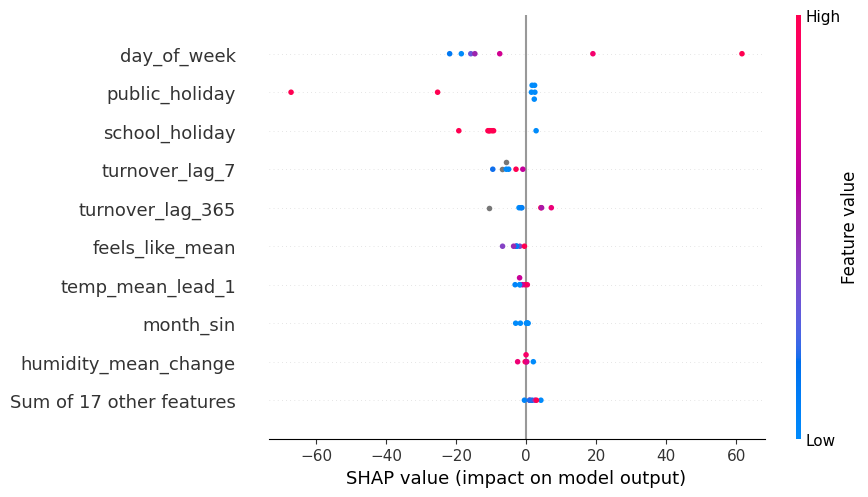

Center | Cakes


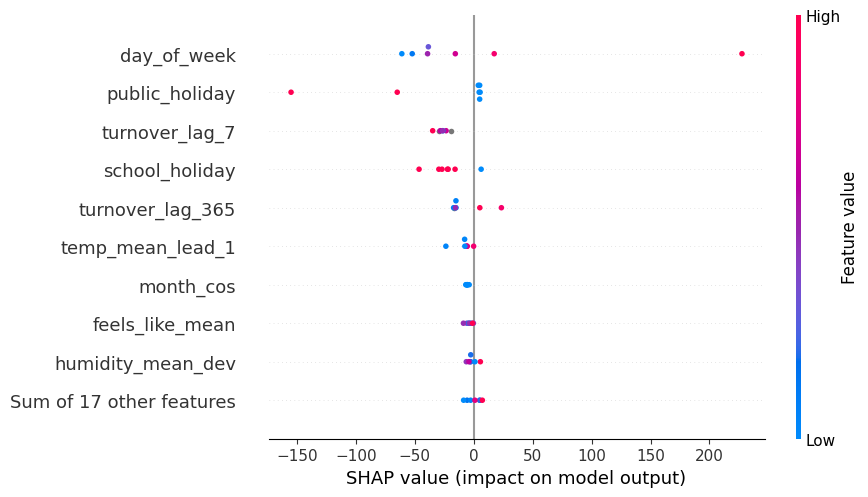

Center | Pastries


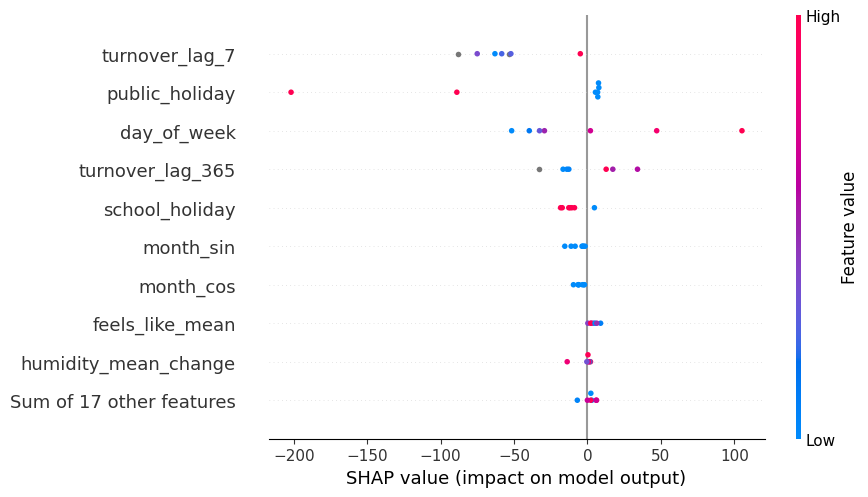

Center | Savoury Snack


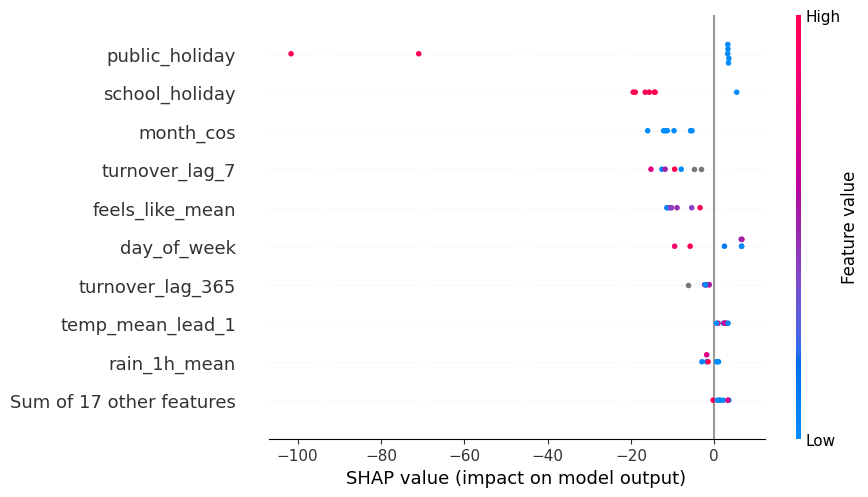

Train_Station | Brown Bread


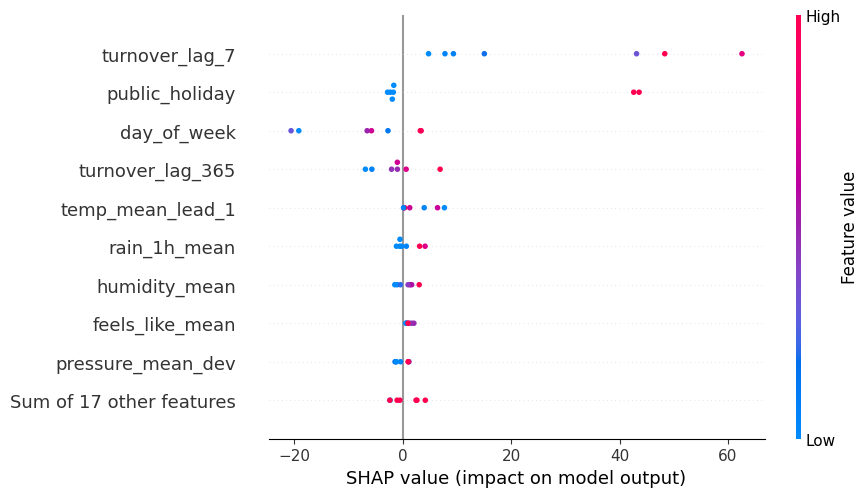

Train_Station | Wheat Rolls


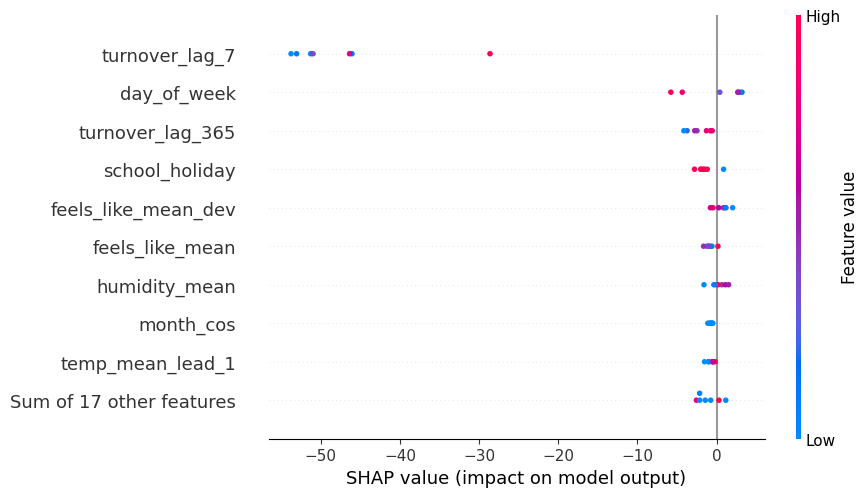

Train_Station | Cakes


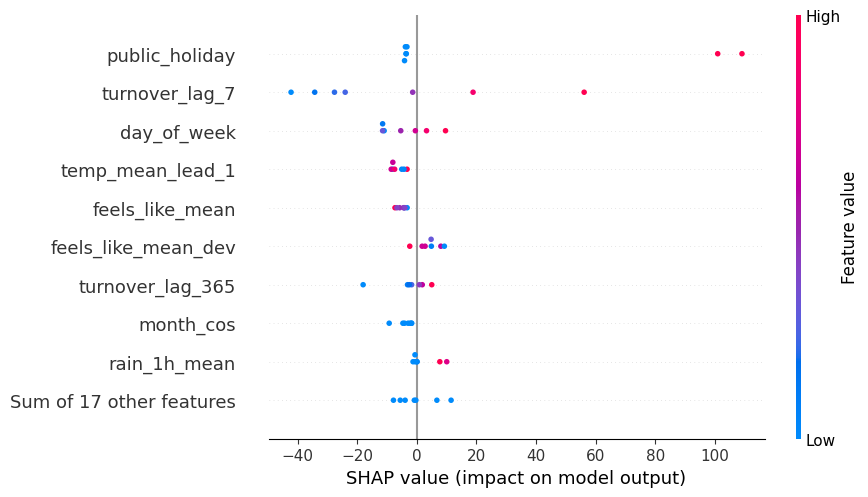

Train_Station | Pastries


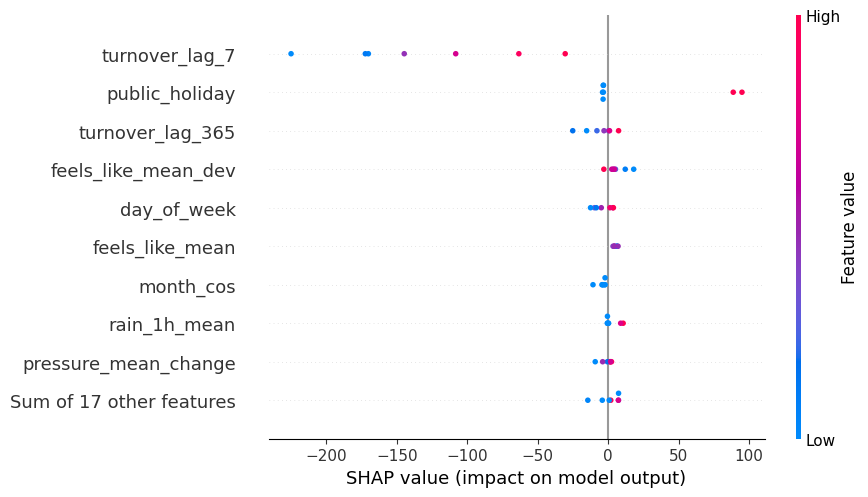

Train_Station | Savoury Snack


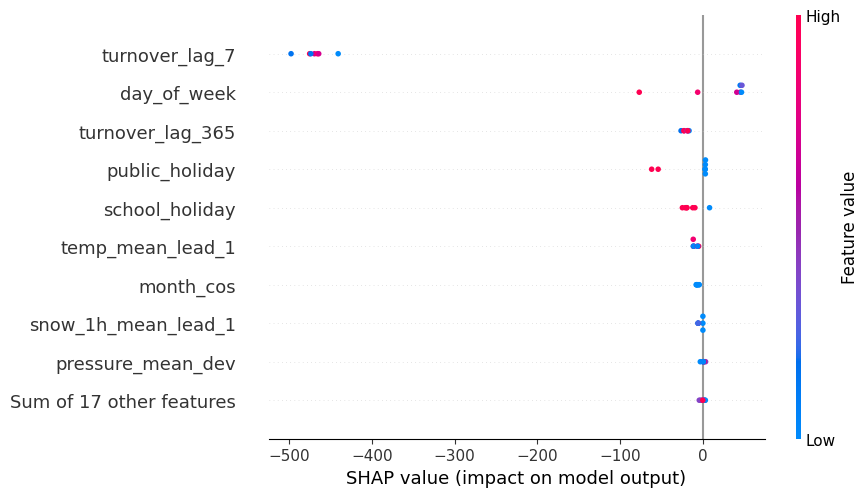

In [70]:
for i in range(len(lgbm_preds['shap'])):
    print(lgbm_preds['group'][i])
    shap.plots.beeswarm(lgbm_preds['shap'][i])

In [71]:
df_test[(df_test['branch']=='Center') & (df_test.index>pd.to_datetime('2018-12-20'))][['turnover', 'turnover_lag_7']].head(20)

turnover  turnover_lag_7
date                                  
2018-12-21  234.605726      212.429125
2018-12-22  373.803915      288.058998
2018-12-23  219.134162      258.569662
2018-12-24  633.150472      172.485611
2018-12-25    1.000000      155.337050
2018-12-26    1.000000      133.840720
2018-12-27  205.094344      146.659763
2018-12-28  193.460212      234.605726
2018-12-29  238.119847      373.803915
2018-12-30  179.218707      219.134162
2018-12-31  427.279444      633.150472
2019-01-01    1.000000             NaN
2019-01-02  145.855441             NaN
2019-01-03  152.599613      205.094344
2019-01-04  188.806222      193.460212
2019-01-05  225.689516      238.119847
2019-01-06  326.522982      179.218707
2019-01-07  180.252458      427.279444
2019-01-08  153.647605             NaN
2019-01-09  161.385971      145.855441

### Error analysis
We will perform an error analysis based on the residuals generated by the optimized LGBM model. To this end, we will first define a utility function to extract observed values, predicted values, and residuals from cross-validation.

In [72]:
# utility function for LightGBM
def get_lgbm_residuals(df_train, grouping_vars, target, features, lgbm_kwargs=None, splits=52, test_size=7, gap=0):
    """Compute residuals based on predictions generated by LightGBM across TimeSeriesSplit Cross-Validation folds.
    Takes in a training dataset of stacked time series and performs TimeSeriesSplit Cross-Validation for LightGBM model 
    for each of those time series. Returns a dataframe of observed and predicted target values and corresponding residuals from
    subsequent cross-validation folds per individual time series.

    Args:
        df_train (pd.DataFrame): A training dataframe containing stacked time series data
        grouping_vars (list): A list of grouping variables, according to which training data is stacked. Currently accepts only a list of two variables.
        target (str): Prediction target
        features (list): List of feature names to be used for training the model
        lgbm_kwargs (dict, optional): Dictionary of LGBM hyperparameters. Defaults to None. If None, model is trained using default hyperparameters.
        splits (int, optional): Number of splits for Cross-Validation. Defaults to 52 (1 fold / week).
        test_size (int, optional): Size of validation set (i.e. forecasting horizon). Defaults to 7 days.
        gap (int, optional): Time gap between end of training and start of validation set. Defaults to 0.

    Returns:
        dict: Dictionary containing datasets of observed and LightGBM-predicted target values and corresponding residuals 
        from subsequent cross-validation folds per time series.
    """
    # initialize dataframe for evaluation scores
    resids = {'group': [], 'combined': []}

    # iterate over all individual series and perform cross-validation
    from itertools import product
    for i, group in enumerate(product(df_train[grouping_vars[0]].unique(), df_train[grouping_vars[1]].unique())):

        # subselect time series
        ts = df_train[(df_train[grouping_vars[0]]==group[0]) & (df_train[grouping_vars[1]]==group[1])].copy()

        # perform cross validation
        tss = TimeSeriesSplit(n_splits=splits, test_size=test_size, gap=gap)
        # initialize empty dataframe for concatenating results from individual cross-validation folds
        combined_local = pd.DataFrame({})
        for train_i, val_i in tss.split(ts):

            train = ts.iloc[train_i]
            val = ts.iloc[val_i]

            # generate target and feature vectors
            X_train = train[features]
            X_val = val[features]
            y_train = train[target]
            y_val = val[target]

            # initialize model
            if lgbm_kwargs==None:
                lgbm = LGBMRegressor(objective='regression', random_state=42)
            else:
                lgbm = LGBMRegressor(objective='regression', random_state=42, **lgbm_kwargs)
            # train model
            lgbm.fit(X_train, y_train)

            y_pred= pd.Series(lgbm.predict(X_val))

            # correct for holiday effects in validation set if necessary
            # if holiday is in validation set, drop elements at corresponding index position in both y_val and y_pred
            if 1 in y_val.unique():
                idx_val = [i for i in range(len(y_val.tolist())) if y_val.tolist()[i]==1]
                y_val = y_val.drop(y_val.index[idx_val])
                y_pred = y_pred.drop(y_pred.index[idx_val])

            combined = pd.DataFrame(y_val.copy())
            combined.columns = ['y_true']
            combined['y_pred'] = y_pred.values
            combined['residual'] = combined['y_true'] - combined['y_pred']

            combined_local = pd.concat([combined_local, combined], axis=0)

        # append scores
        resids['group'].append(f'{group[0]} | {group[1]}')
        resids['combined'].append(combined_local)
    
    return resids

In [73]:
lgbm_resids = get_lgbm_residuals(df_train, grouping_vars=['branch', 'product'], target='turnover', features=lgbm_features,
                            lgbm_kwargs=params_optimal, splits=52)

In [74]:
lgbm_resids['combined'][0]

y_true      y_pred   residual
date                                         
2017-01-02  212.088831  231.028329 -18.939498
2017-01-03  185.007714  213.171850 -28.164136
2017-01-04  186.334185  209.565221 -23.231035
2017-01-05  242.885652  184.276785  58.608866
2017-01-06  115.479505  183.121552 -67.642047
...                ...         ...        ...
2017-12-27  229.406274  168.834869  60.571405
2017-12-28  142.791635  157.259542 -14.467907
2017-12-29  198.931182  160.264289  38.666893
2017-12-30  199.000275  154.115171  44.885104
2017-12-31  125.655626  124.893016   0.762610

[364 rows x 3 columns]

In [75]:
# make path for saving residuals
#os.mkdir('../models/lgbm_optimized/residuals/')

In [76]:
# save residuals in separate folder
for i in range(len(lgbm_resids['group'])):
    group = lgbm_resids['group'][i].split(' | ')
    filename = f'{group[0]}_{group[1]}'
    lgbm_resids['combined'][i].to_csv(f'../models/lgbm_optimized/residuals/residuals_{filename}.csv', index=False)

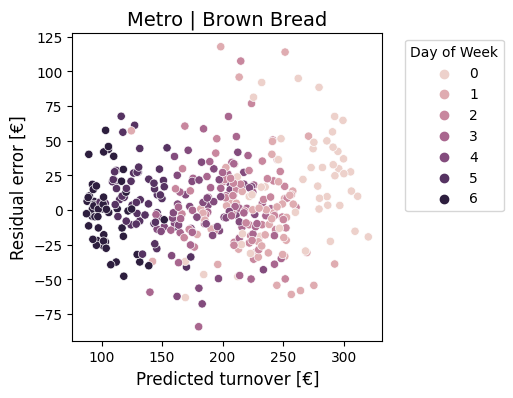

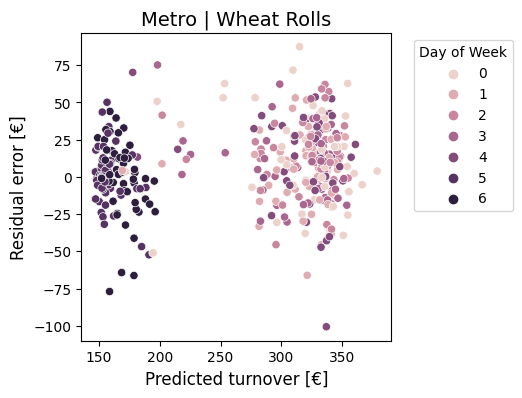

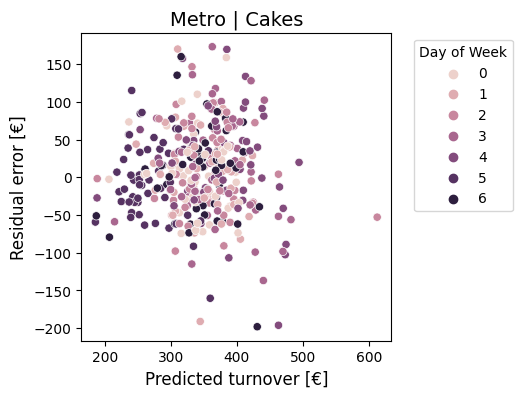

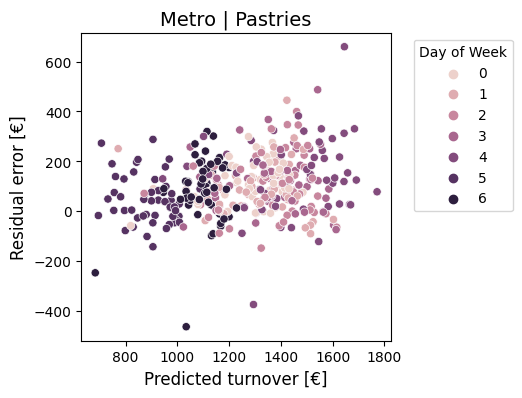

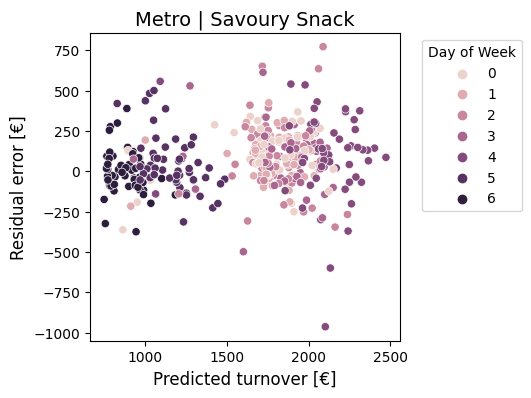

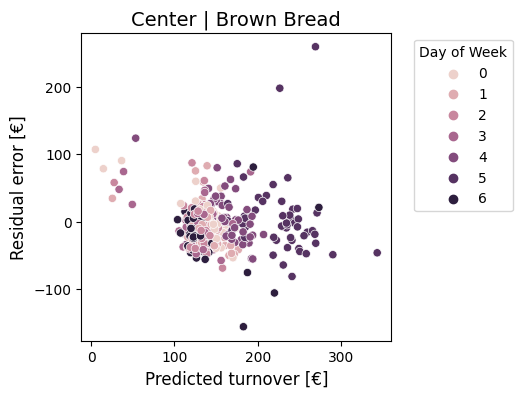

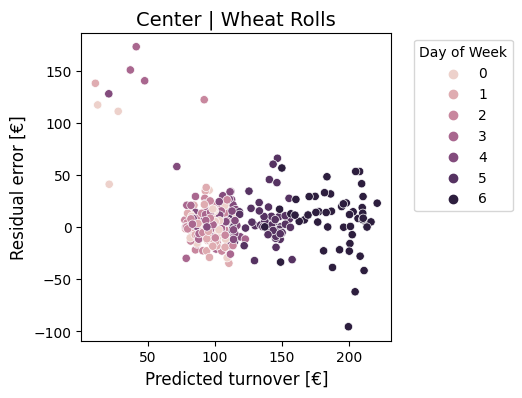

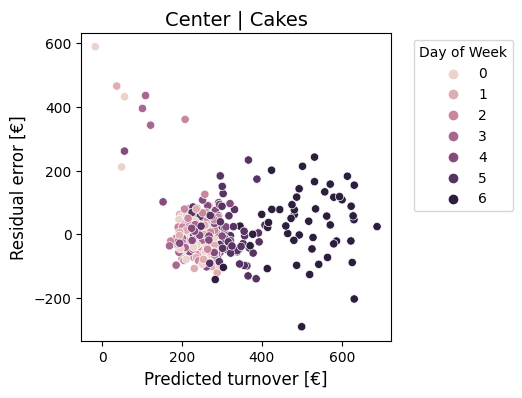

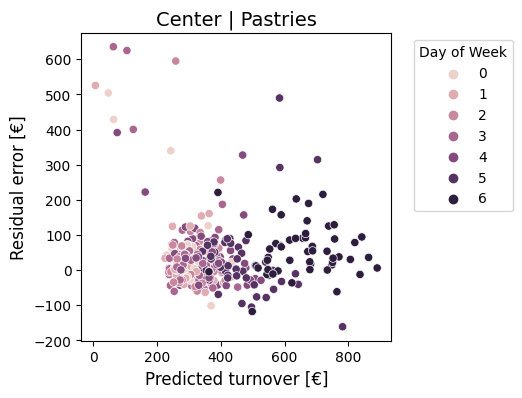

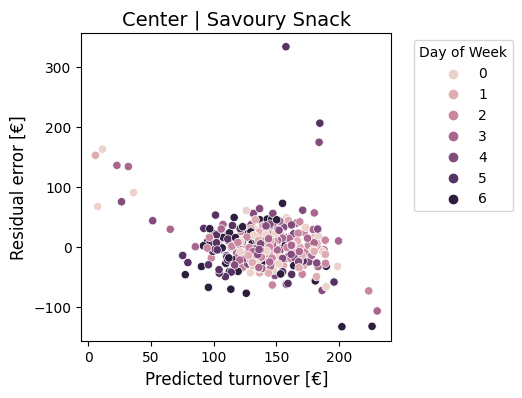

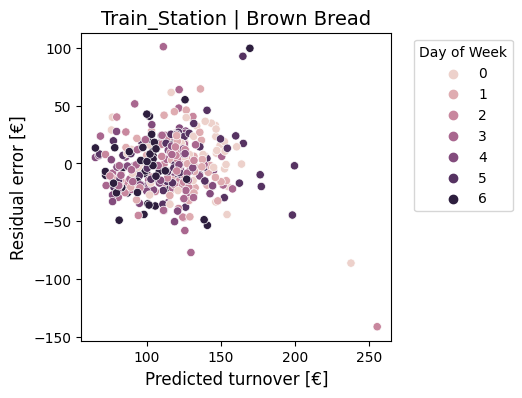

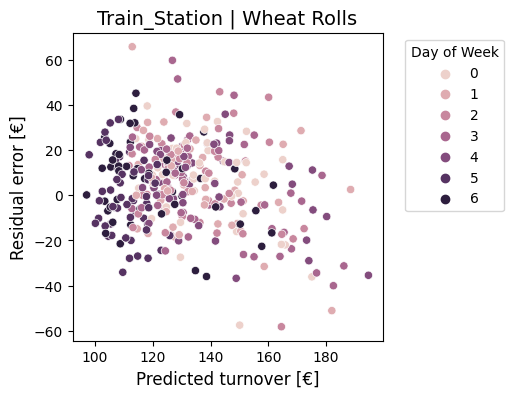

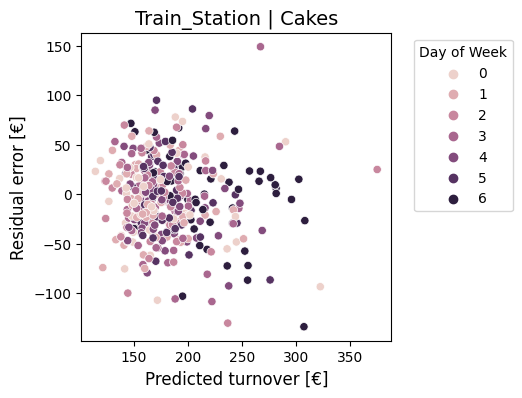

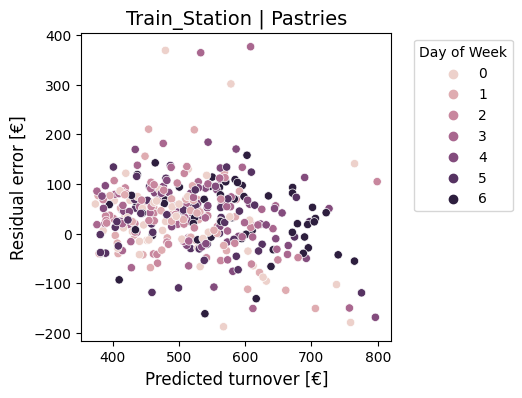

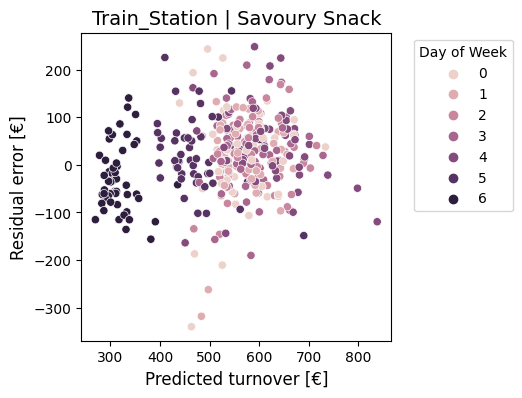

In [77]:
for i in range(len(lgbm_resids['group'])):
    data = lgbm_resids['combined'][i]
    branch = lgbm_resids['group'][i].split(' | ')[0]
    product = lgbm_resids['group'][i].split(' | ')[1]
    data = data.merge(df_train[(df_train['branch']==branch) & (df_train['product']==product)], 
                        left_index=True, right_index=True, how='left')
    title = lgbm_resids['group'][i]
    plt.figure(figsize=(4,4))
    sns.scatterplot(data=data, x='y_pred', y='residual', hue='day_of_week')
    plt.ylabel('Residual error [€]', fontsize=12)
    plt.xlabel('Predicted turnover [€]', fontsize=12)
    plt.legend(title='Day of Week', bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.title(f'{title}', fontsize=14)
    plt.show()